In [1]:
"""
Spyder Editor

This is the main source file for ChromaStarPy.  We start here.
"""

"""/*
 * The MIT License (MIT)
 * Copyright (c) 2016 C. Ian Short 
 *
 * Permission is hereby granted, free of charge, to any person 
 obtaining a copy of this software and associated documentation 
 files (the "Software"), to deal in the Software without 
 restriction, including without limitation the rights to use, 
 copy, modify, merge, publish, distribute, sublicense, and/or 
 sell copies of the Software, and to permit persons to whom the 
 Software is furnished to do so, subject to the following 
 conditions:
 *
 * The above copyright notice and this permission notice shall 
 be included in all copies or substantial portions of the 
 Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY 
 KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE 
 WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE 
 AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
 HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
 WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING 
 FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
 OTHER DEALINGS IN THE SOFTWARE.
*
 * To change this license header, choose License Headers in 
 Project Properties.
 * To change this template file, choose Tools | Templates
 * and open the template in the editor.
 */"""

#############################################
#
#
#
#    Initial set-up:
#     - import all python modules
#     - set input parameters for *everything* (atmospheric modeling
#        spectrum synthesis, user-defined 2-level atom & line, 
#        post-processing, ...)
#     - prepare reference solar model and template models
#        for re-scaling to initial guess
#     
#
#
##############################################



#from decimal import Decimal as D
import math
import Useful
 
import LamGrid
import TauScale
import ScaleSolar
import State
import Hydrostat
import ScaleT4250g20
import ScaleT5000
import ScaleT10000
import LevelPopsServer
import Kappas
import KappasMetal
import KappasRayl
import DepthScale
import IonizationEnergy
import PartitionFn
import AtomicMass
import ToolBox
import Thetas
import MolecData
import Jola
import SpecSyn
import HjertingComponents
import LineGrid
import LineProf
import LineKappa
import LineTau2
import FormalSoln
import Flux
import LDC
import PostProcess

#plotting:
import matplotlib
%matplotlib inline
import pylab

#color platte for pylab plotting
palette = ['black', 'brown','red','orange','yellow','green','blue','indigo','violet']
numClrs = len(palette)


#General file for printing ad hoc quantities
dbgHandle = open("debug.out", 'w')

absPath = "C:/Users/ishort/Documents/ChromaStarJupyter/"
outPath = absPath + "Outputs/"


############################
#
#
#  Input parameters
#
#
############################

#
#Model atmosphere
teffStr = "3750.0"    #K
loggStr = "4.5"      #cgs
logZStr = "0.0"   #[M/H]
massStarStr = "1.0"   #   solar masses
xiTStr = "1.0"   #km/s

#
#Spectrum synthesis
lambdaStartStr = "515.5"    #   nm    
lambdaStopStr = "522.5"  #   nm
lineThreshStr = "-3.0"   # min log(KapLine/kapCnt) for inclusion at all - areally, being used as "lineVoigt" for now
voigtThreshStr = "-3.0"   #  min log(KapLine/kapCnt) for treatment as Voigt - currently not used - all lines get Voigt
logGammaColStr = "0.0"
logKapFudgeStr = "0.0"
macroVStr = "1.0"  #   km/s
rotVStr = "1.0"  # km/s
rotIStr = "90.0"   # degrees
RVStr = "0.0"  # km/s
vacAir = "vacuum"    
sampling = "fine"

#
#Performance vs realism
nOuterIterStr = "8"  #   no of outer Pgas(HSE) - EOS - kappa iterations
nInnerIterStr = "8"   # no of inner (ion fraction) - Pe iterations
ifTiOStr = "1"   #  where to include TiO JOLA bands in synthesis 

#
#Gaussian filter for limb darkening curve, fourier transform
diskLambdaStr = "500.0"   #   nm
diskSigmaStr = "0.01"  #   nm

#
#Two-level atom and spectral line
userLam0Str = "589.592" #  nm 
userA12Str = "6.24"  #  A_12 logarithmic abundance = log_10(N/H_H) = 12
userLogFStr = "-0.495" # log(f) oscillaotr strength // saturated line
userStageStr = "0" #  ionization stage of user species (0 (I) - 3 (IV)
userChiI1Str = "5.139" # ground state chi_I, eV
userChiI2Str = "47.29" # 1st ionized state chi_I, eV
userChiI3Str = "71.62" # 2nd ionized state chi_I, eV
userChiI4Str = "98.94" # 3rd ionized state chi_I, eV
userChiLStr = "0.0"  # lower atomic E-level, eV
userGw1Str = "2" # ground state state. weight or partition fn (stage I) - unitless
userGw2Str = "1" # ground state state. weight or partition fn (stage II) - unitless
userGw3Str = "1" #  ground state state. weight or partition fn (stage III) - unitless
userGw4Str = "1" # ground state state. weight or partition fn (stage IV) - unitless
userGwLStr = "2" #  lower E-level state. weight - unitless
userMassStr = "22.9" # amu
userLogGammaColStr = "1.0" # log_10 Lorentzian broadening enhancement factor


###################################
#
#
# End input parameters
#
#
###################################
                                                    
                                                    
#For the notebook version, set the input parameters in the notebook (above)instead of reading them from a 
#file.  So, following input block commented out:
"""
lbl = ""
inLine = ""
fields = [" " for i in range(2)] 

#with open("ChromaStarPy.input.txt", 'r', encoding='utf-8') as inputHandle:
inFile = absPath + "ChromaStarPy.input.txt"
with open(inFile, 'r') as inputHandle:    
    
    #These MUST be in the following order in the input file, 
    #one lable/value pair per line and the lable and the value
    #MUST be separated by a comma
    #Model atmosphere:
    inLine = inputHandle.readline()   #Section header
    print(inLine)
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); teffStr = fields[1].strip()    # K
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); loggStr = fields[1].strip()   # log cgs
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); logZStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); massStarStr = fields[1].strip()   #solar masses
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); xiTStr = fields[1].strip()   #km/s
    
    #Spectrum synthesis
    inLine = inputHandle.readline()   #Section header
    print(inLine)
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); lambdaStartStr = fields[1].strip()   #nm
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); lambdaStopStr = fields[1].strip()   #nm
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #opacity threshold for inclusion at all - all ines currently treated with Voigt profile
    lbl = fields[0].strip(); lineThreshStr = fields[1].strip()   #min log(kapLine/kapCnt)
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #opacity threshold for treatment with Voigt profile - currently not used
    lbl = fields[0].strip(); voigtThreshStr = fields[1].strip()  #min log(kapLine/kapCnt)
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #Lorentzian broadening enhancement factor
    lbl = fields[0].strip(); logGammaColStr = fields[1].strip()
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #continuous background opacity enhancement factor
    lbl = fields[0].strip(); logKapFudgeStr = fields[1].strip()
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    lbl = fields[0].strip(); macroVStr = fields[1].strip()  #km/s
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #linear surface equatorial rot velocity
    lbl = fields[0].strip(); rotVStr = fields[1].strip()  #km/s
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    #inclination of rot axis defined wrt to line-of-sight
    lbl = fields[0].strip(); rotIStr = fields[1].strip()  #degrees
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    lbl = fields[0].strip(); RVStr = fields[1].strip()   #km/s
    inLine = inputHandle.readline()    
    fields = inLine.split(",")
    lbl = fields[0].strip(); vacAir = fields[1].strip()
    inLine = inputHandle.readline() 
    fields = inLine.split(",")
    #spectral lines sampled with "coarse" or "fine" lambda grid
    lbl = fields[0].strip(); sampling = fields[1].strip()
    
    #Performance vs realism
    inLine = inputHandle.readline()   #Section header
    print(inLine)
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    #no. outer Pgas(HSE) - EOS - kappa iterations
    lbl = fields[0].strip(); nOuterIterStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    #no. inner (ion fraction)-Pe iterations
    lbl = fields[0].strip(); nInnerIterStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    #Include TiO bands with JOLA treatment?
    lbl = fields[0].strip(); ifTiOStr = fields[1].strip()
    
    #Gaussian filter for limb darkening curve, fourier transform
    inLine = inputHandle.readline()   #Section header
    print(inLine)
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); diskLambdaStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); diskSigmaStr = fields[1].strip()
    
    #User-defined two-level atom and spectral line profile
    inLine = inputHandle.readline()   #Section header
    print(inLine)
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userLam0Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userA12Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userLogFStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userStageStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userChiI1Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userChiI2Str = fields[1].strip()    
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userChiI3Str = fields[1].strip()    
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userChiI4Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userChiLStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userGw1Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userGw2Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userGw3Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userGw4Str = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userGwLStr = fields[1].strip()   
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userMassStr = fields[1].strip()
    inLine = inputHandle.readline()
    fields = inLine.split(",")
    lbl = fields[0].strip(); userLogGammaColStr = fields[1].strip()
"""    
 

#True for Voigt computed with true convolution instead of power-law expansion approx - probably not working well right now
ifVoigt = False
#Scattering term in line source fn - not yet enabled   
ifScatt = False 

#// Argument 0: Effective temperature, Teff, in K:
teff = float(teffStr)        
#print(type(teff))

#// Argument 1: Logarithmic surface gravity, g, in cm/s/s:
logg = float(loggStr)

#//Argument 2: Linear sclae factor for solar Rosseland oapcity distribution
log10ZScale = float(logZStr)

#//Argument 3: Stellar mass, M, in solar masses
massStar = float(massStarStr)

#// Sanity check:
F0Vtemp = 7300.0;  #// Teff of F0 V star (K)                           
if (teff < 3700.0): 
    teff = 3700.0
    teffStr = "3700"

if (teff > 50000.0):
    teff = 50000.0
    teffStr = "50000"
    
#//logg limit is strongly Teff-dependent:
minLogg = 3.0; #//safe initialization
minLoggStr = "3.0";
if (teff <= 4000.0):
    minLogg = 0.0
    minLoggStr = "0.0"
elif ((teff > 4000.0) and (teff <= 5000.0)): 
    minLogg = 0.5
    minLoggStr = "0.5"
elif ((teff > 5000.0) and (teff <= 6000.0)): 
    minLogg = 1.5
    minLoggStr = "1.5"
elif ((teff > 6000.0) and (teff <= 7000.0)): 
    minLogg = 2.0
    minLoggStr = "2.0"
elif ((teff > 7000.0) and (teff < 9000.0)): 
    minLogg = 2.5
    minLoggStr = "2.5"
elif (teff >= 9000.0): 
    minLogg = 3.0
    minLoggStr = "3.0"

if (logg < minLogg): 
    logg = minLogg
    loggStr = minLoggStr

if (logg > 7.0): 
    logg = 7.0
    loggStr = "7.0"
        
if (log10ZScale < -3.0): 
    log10ZScale = -3.0
    logZStr = "-3.0"
        
if (log10ZScale > 1.0): 
    log10ZScale = 1.0
    logZStr = "1.0"

if (massStar < 0.1): 
    massStar = 0.1
    massStarStr = "0.1"
        
if (massStar > 20.0): 
    massStar = 20.0
    massStarStr = "20.0"

grav = math.pow(10.0, logg)
zScale = math.pow(10.0, log10ZScale)

#// Argument 5: microturbulence, xi_T, in km/s:
xiT = float(xiTStr)

if (xiT < 0.0): 
    xiT = 0.0
    xitStr = "0.0"
        
if (xiT > 8.0): 
    xiT = 8.0
    xitStr = "8.0"
        

#// Argument 6: minimum ratio of monochromatic line center to background continuous
#// extinction for inclusion of linein spectrum 
#lineThreshStr = args[5];
#lineThreshStr = "-3.0"; #//test
lineThresh = float(lineThreshStr)

if (lineThresh < -4.0): 
    lineThresh = -4.0
    lineThreshStr = "-4.0"
        
if (lineThresh > 6.0): 
    lineThresh = 6.0
    lineThreshStr = "6.0"
        

#// Argument 7: minimum ratio of monochromatic line center to background continuous
voigtThresh = float(voigtThreshStr);

if (voigtThresh < lineThresh): 
    voigtThresh = lineThresh
    voigtThreshStr = lineThreshStr
        
if (voigtThresh > 6.0): 
    voigtThresh = 6.0
    voigtThreshStr = "6.0"
        
#//User defined spetrum synthesis region:
lamUV = 260.0;
lamIR = 2600.0;

#// Argument 8: starting wavelength for spectrum synthesis 

lambdaStart = float(lambdaStartStr)

if (lambdaStart < lamUV): 
    lambdaStart = lamUV
    lambdaStartStr = str(lamUV)
        
if (lambdaStart > lamIR - 1.0): 
    lambdaStart = lamIR - 1.0
    lambdaStartStr = str(lamIR - 1.0)
        
#// Argument 9: stopping wavelength for spectrum synthesis 
lambdaStop = float(lambdaStopStr)

if (lambdaStop < lamUV + 1.0): 
    lambdaStop = lamUV + 1.0
    lambdaStartStr = str(lamUV + 1.0)
        
if (lambdaStop > lamIR):
    lambdaStop = lamIR
    lambdaStartStr = str(lamIR)

#//Prevent negative or zero lambda range:
if (lambdaStop <= lambdaStart):
    lambdaStop = lambdaStart + 0.5 #//0.5 nm = 5 A
    lambdaStopStr = str(lambdaStop)
""" 
"""
#//limit size of synthesis region (nm):
maxSynthRange = 5.0 #//set default to minimum value //nm
#//if we're not in the blue we can get away wth more:
if (lambdaStart > 350.0):
    maxSynthRange = 10.0
if (lambdaStart > 550.0):
    maxSynthRange = 20.0
if (lambdaStart > 700.0):
    maxSynthRange = 50.0
if (lambdaStart > 1000.0):
    maxSynthRange = 100.0
if (lambdaStart > 1600.0):
    maxSynthRange = 200.0

#//console.log("maxSynthRange " + maxSynthRange + " lambdaStop " + lambdaStop);
if (lambdaStop > (lambdaStart+maxSynthRange)):
    #//console.log("lambdaStop > (lambdaStart+maxSynthRange) condition");
    lambdaStop = lambdaStart + maxSynthRange #//10 nm = 100 A
    lambdaStopStr = str(lambdaStop)
#//console.log("lambdaStop " + lambdaStop);
"""
""" 
if (lambdaStop > lamIR):
    #//console.log("lambdaStop > lamIR condition");
    lambdaStop = lamIR
    lambdaStopStr = str(lamIR)

#//console.log("lambdaStop " + lambdaStop);

nm2cm = 1.0e-7
cm2nm = 1.0e7     
lambdaStart = nm2cm * lambdaStart #//nm to cm 
lambdaStop = nm2cm * lambdaStop  #//nm to cm
lamUV = nm2cm * lamUV
lamIR = nm2cm * lamIR
      
#//argument 10: line sampling selection (fine or coarse)
#sampling = "fine"

#// Argument 11: Lorentzian line broadening enhancement 
logGammaCol = float(logGammaColStr)

if (logGammaCol < 0.0):
    logGammaCol = 0.0
    logGammaColStr = "0.0"
        
if (logGammaCol > 1.0):
    logGammaCol = 1.0
    logGammaColStr = "1.0"
        
#// Argument 12: log_10 gray mass extinction fudge 
logKapFudge = float(logKapFudgeStr)

if (logKapFudge < -2.0):
    logKapFudge = -2.0
    logKapFudgeStr = "-2.0"
        
if (logKapFudge > 2.0):
    logKapFudge = 2.0
    logKapFudgeStr = "2.0"
        

#// Argument 13: macroturbulent velocity broadening parameter (sigma) (km/s) 
macroV = float(macroVStr)
#// Argument 14: surface equatorial linear rotational velocity (km/s) 
rotV  = float(rotVStr)
#// Argument 15: inclination of rotation axis wrt line-of-sight (degrees) 
rotI  = float(rotIStr)

#// Argument 16: number of outer HSE-EOS-Opac iterations
nOuterIter = int(nOuterIterStr)
#// Argument 17: number of inner Pe-IonFrac iterations
nInnerIter = int(nInnerIterStr)
#//Argument 18: If TiO JOLA bands should be included:
ifTiO = int(ifTiOStr)

if (macroV < 0.0):
    macroV = 0.0
    macroVStr = "0.0"
        
if (macroV > 8.0):
    macroV = 8.0
    macroVStr = "8.0"
        

if (rotV < 0.0):
    rotV = 0.0
    rotVStr = "0.0"
        
if (rotV > 20.0):
    rotV = 20.0
    rotVStr = "20.0"
        

if (rotI < 0.0): 
    rotI = 0.0
    rotIStr = "0.0"
        
if (rotI > 90.0):
    rotI = 90.0
    rotIStr = "90.0"
        
if (nOuterIter < 1): 
    nOuterIter = 1
    nOuterIterStr = "1"
        
if (nOuterIter > 12):
    nOuterIter = 12
    nOuterIterStr = "12"
        
if (nInnerIter < 1):
    nInnerIter = 1
    nInnerIterStr = "1"
        
if (nInnerIter > 12):
    nInnerIter = 12
    nInnerIterStr = "12"
    
#//For rotation:
inclntn = math.pi * rotI / 180.0  #//degrees to radians
vsini = rotV * math.sin(inclntn)

#// Argument 19: wavelength of narrow Gaussian filter in nm
diskLambda = float(diskLambdaStr)  #//nm
#// Argument 20: bandwidth, sigma, of narrow Gaussian filter in nm
diskSigma = float(diskSigmaStr)  #//nm
#// Argument 21: radial velocity of star in km/s
RV = float(RVStr)  #//nm   
#// Argument 22: Spectrum synthesis wavelength scale options:

if (diskLambda < lamUV):
    diskLambda = lamUV
    diskLambdaStr = str(lamUV)    
if (diskLambda > lamIR):
    diskLambda = lamIR
    diskLambdaStr = str(lamIR)
    
if (diskSigma < 0.005):
    diskSigma = 0.005
    diskSigmaStr = "0.005";
if (diskSigma > 10.0):
    diskSigma = 10.0
    diskSigmaStr = "10"
    
if (RV < -200.0):
    RV = -200.0
    RVStr = "-200"
if (RV > 200.0):
    RV = 200.0
    RVStr = "200"
    
#vacAir = "vacuum" #//test

#// Representative spectral line and associated atomic parameters
#//

userLam0 = float(userLam0Str)
userA12 = float(userA12Str)
userLogF = float(userLogFStr)
userStage = float(userStageStr)
userChiI1 = float(userChiI1Str)
userChiI2 = float(userChiI2Str)
userChiI3 = float(userChiI3Str)
userChiI4 = float(userChiI4Str)
userChiL = float(userChiLStr)
userGw1 = float(userGw1Str)
userGw2 = float(userGw2Str)
userGw3 = float(userGw3Str)
userGw4 = float(userGw4Str)
userGwL = float(userGwLStr)
userMass = float(userMassStr)
userLogGammaCol = float(userLogGammaColStr)

if (userLam0 < 260.0):
    userLam0 = 260.0
    userLamStr = "260"
if (userLam0 > 2600.0):
    userLam0 = 2600.0
    userLamStr = "2600"

if (userA12 < 2.0):
    userA12 = 2.0
    userNStr = "2.0"
#//Upper limit set high to accomodate Helium!:
if (userA12 > 11.0):
    userA12 = 11.0
    userNStr = "11.0"

if (userLogF < -6.0):
    userLogF = -6.0
    userFStr = "-6.0"
if (userLogF > 1.0):
    userLogF = 1.0
    userFStr = "1.0"

if ( (userStage != 0) and (userStage != 1) and (userStage != 2) and (userStage != 3) ):
    userStage = 0
    userStageStr = "I"

if (userChiI1 < 3.0):
    userChiI1 = 3.0
    userIonStr = "3.0"
if (userChiI1 > 25.0):
    userChiI1 = 25.0
    userIonStr = "25.0"

if (userChiI2 < 5.0):
    userChiI2 = 5.0
    userIonStr = "5.0"
if (userChiI2 > 55.0):
    userChiI2 = 55.0
    userIonStr = "55.0"

if (userChiI3 < 5.0):
    userChiI3 = 5.0
    userIonStr = "5.0"
if (userChiI3 > 55.0):
    userChiI3 = 55.0
    userIonStr = "55.0"

if (userChiI4 < 5.0):
    userChiI4 = 5.0
    userIonStr = "5.0"
if (userChiI4 > 55.0):
    userChiI4 = 55.0
    userIonStr = "55.0"

#// Note: Upper limit of chiL depends on value of chiI1 above!
if (userChiL < 0.0):
    userChiL = 0.0 #// Ground state case!
    userExcStr = "0.0"
if ( (userStage == 0) and (userChiL >= userChiI1) ):
    #//ionized = false;
    userChiL = 0.9 * userChiI1
    userExcStr = userIonStr

if ( (userStage == 1) and (userChiL >= userChiI2) ):
    #//ionized = false;
    userChiL = 0.9 * userChiI2
    userExcStr = userIonStr

if ( (userStage == 2) and (userChiL >= userChiI3) ):
    #//ionized = false;
    userChiL = 0.9 * userChiI3
    userExcStr = userIonStr

if ( (userStage == 3) and (userChiL >= userChiI4) ):
    #//ionized = false;
    userChiL = 0.9 * userChiI4
    userExcStr = userIonStr

if (userGw1 < 1.0):
    userGw1 = 1.0
    userWghtStr = "1"
if (userGw1 > 100.0):
    userGw1 = 100.0
    userWghtStr = "100"

if (userGw2 < 1.0):
    userGw2 = 1.0
    userWghtStr = "1";
if (userGw2 > 100.0):
    userGw2 = 100.0
    userWghtStr = "100";

if (userGw3 < 1.0):
    userGw3 = 1.0
    userWghtStr = "1"
if (userGw3 > 100.0):
    userGw3 = 100.0
    userWghtStr = "100"

if (userGw4 < 1.0):
    userGw4 = 1.0
    userWghtStr = "1"
if (userGw4 > 100.0):
    userGw4 = 100.0
    userWghtStr = "100"

if (userGwL < 1.0):
    userGwL = 1.0
    userLWghtStr = "1"
if (userGwL > 100.0):
    userGwL = 100.0
    userLWghtStr = "100"

if (userMass < 1.0):
    userMass = 1.0
    userMassStr = "1.0"
if (userMass > 200.0):
    userMass = 200.0
    userMassStr = "200"
    
if (userLogGammaCol < 0.0):
    userLogGammaCol = 0.0
    userGamStr = "0.0"
if (userLogGammaCol > 1.0):
    userLogGammaCol = 1.0
    userGamStr = "1.0"

userLam0 = userLam0 * nm2cm #// line centre lambda from nm to cm

#Create output file

#File for structure output:
strucStem = "Teff" + teffStr + "Logg" + loggStr + "Z" + logZStr + "M" + massStarStr+"xiT"+xiTStr
strucFile = "struc." + strucStem + ".out"
struc2File = "struc." + strucStem + ".2.out"
specFile = "spec." + strucStem + "L"+lambdaStartStr+"-"+lambdaStopStr+"xiT"+xiTStr+"LThr"+lineThreshStr+ \
"Mac"+macroVStr+"Rot"+rotVStr+"-"+rotIStr+"RV"+RVStr + ".out"
sedFile = "sed." + strucStem + "L"+lambdaStartStr+"-"+lambdaStopStr+"xiT"+xiTStr+"lThr"+lineThreshStr+ \
"Mac" + macroVStr + "Rot"+rotVStr+"-"+rotIStr+"RV"+ RVStr + ".out" 
ldcFile = "ldc." + strucStem + "L" + diskLambdaStr + "S" + diskSigmaStr + ".out"
lineFile = "line." + strucStem + "L0" + userLam0Str + ".out"

#Echo input parameters *actually used* to console:
inputParamString = "Teff " + str(teff) + " logg " + str(logg) + " [Fe/H] " + str(log10ZScale) + " massStar " + \
      str(massStar) + " xiT " + str(xiT) + " lineThresh " + str(lineThresh) + " voigtThresh " + \
      str(voigtThresh) + " lambda0 " + str(lambdaStart) + " lambda1 " + str(lambdaStop) + " logGamCol " + \
      str(logGammaCol) + " logKapFudge " + str(logKapFudge) + " macroV " + str(macroV) + " rotV " + str(rotV) + \
      " rotI " + str(rotI) + " RV " + str(RV) + " nInner " + str(nInnerIter) + " nOuter " + str(nOuterIter) + \
      " ifTiO " + str(ifTiO) + " sampling " + sampling
print(inputParamString)
 
#// Wavelengths in Air : 
#    if ($("#air").is(":checked")) {
#        vacAir = $("#air").val(); // radio 
#    }
#// Wavelengths in vacuum: (default)
#    if ($("#vacuum").is(":checked")) {
#       vacAir = $("#vacuum").val(); // radio 
#    }
    
#//
#// ************************ 
#//
#//  OPACITY  PROBLEM #1 - logFudgeTune:  late type star coninuous oapcity needs to have by multiplied 
#//  by 10.0^0.5 = 3.0 for T_kin(tau~1) to fall around Teff and SED to look like B_lmabda(Trad=Teff).
#//   - related to Opacity problem #2 in LineKappa.lineKap() - ??
#//
logFudgeTune = 0.0
#//sigh - don't ask me - makes the Balmer lines show up around A0:
if (teff <= F0Vtemp):
    logFudgeTune = 0.5
      
if (teff > F0Vtemp):
    logFudgeTune = 0.0

logTotalFudge = logKapFudge + logFudgeTune

logE = math.log10(math.e) #// for debug output
logE10 = math.log(10.0) #//natural log of 10

#//Gray structure and Voigt line code code begins here:
#// Initial set-up:
#// optical depth grid
numDeps = 48
log10MinDepth = -6.0
log10MaxDepth = 2.0
#//int numThetas = 10;  #// Guess

#//wavelength grid (cm):
lamSetup = []
for i in range(3):
    lamSetup.append(0.0)

lamSetup[0] = 260.0 * nm2cm  #// test Start wavelength, cm
#lamSetup[0] = 100.0 * 1.0e-7;  // test Start wavelength, cm
lamSetup[1] = 2600.0 * nm2cm #// test End wavelength, cm
lamSetup[2] = 350;  #// test number of lambda
#//int numLams = (int) (( lamSetup[1] - lamSetup[0] ) / lamSetup[2]) + 1;  
numLams = int(lamSetup[2])

#//CONTINUUM lambda scale (nm)
lambdaScale = LamGrid.lamgrid(numLams, lamSetup) #//cm
        
#// Solar parameters:
teffSun = 5778.0
loggSun = 4.44
gravSun = math.pow(10.0, loggSun)
log10ZScaleSun = 0.0
zScaleSun = math.exp(log10ZScaleSun)

#//Solar units:
massSun = 1.0
radiusSun = 1.0
#//double massStar = 1.0; //solar masses // test
logRadius = 0.5 * (math.log(massStar) + math.log(gravSun) - math.log(grav))
radius = math.exp(logRadius); #//solar radii
#//double radius = Math.sqrt(massStar * gravSun / grav); // solar radii
logLum = 2.0 * math.log(radius) + 4.0 * math.log(teff / teffSun)
bolLum = math.exp(logLum) #// L_Bol in solar luminosities 
#//cgs units:
rSun = 6.955e10 #// solar radii to cm

cgsRadius = radius * rSun
omegaSini = (1.0e5 * vsini) / cgsRadius #// projected rotation rate in 1/sec
macroVkm = macroV * 1.0e5  #//km/s to cm/s

#//Composition by mass fraction - needed for opacity approximations
#//   and interior structure
massX = 0.70 #//Hydrogen
massY = 0.28 #//Helium
massZSun = 0.02 #// "metals"
massZ = massZSun * zScale #//approximation

#//double logNH = 17.0

#//
#////Detailed checmical composition:
#//Abundance table adapted from PHOENIX V. 15 input bash file
#// Grevesse Asplund et al 2010
#//Solar abundances:
#// c='abundances, Anders & Grevesse',

nelemAbnd = 41
numStages = 7
  
nome = [0 for i in range(nelemAbnd)] 
eheu = [0.0 for i in range(nelemAbnd)] #log_10 "A_12" values
logAz = [0.0 for i in range(nelemAbnd)] #N_z/H_H for element z
cname = ["" for i in range(nelemAbnd)]
logNH = [0.0 for i in range(numDeps)]
#double[][] logNz = new double[nelemAbnd][numDeps]; //N_z for element z
logNz = [ [ 0.0 for i in range(numDeps) ] for j in range(nelemAbnd) ] #N_z for element z
#double[][][] masterStagePops = new double[nelemAbnd][numStages][numDeps];
masterStagePops = [ [ [ 0.0 for i in range(numDeps) ] for j in range(numStages) ] for k in range(nelemAbnd) ]

#//nome is the Kurucz code - in case it's ever useful
nome[0]=   100 
nome[1]=   200 
nome[2]=   300 
nome[3]=   400 
nome[4]=   500 
nome[5]=   600 
nome[6]=   700 
nome[7]=   800 
nome[8]=   900 
nome[9]=  1000 
nome[10]=  1100 
nome[11]=  1200 
nome[12]=  1300 
nome[13]=  1400 
nome[14]=  1500 
nome[15]=  1600 
nome[16]=  1700 
nome[17]=  1800 
nome[18]=  1900 
nome[19]=  2000 
nome[20]=  2100 
nome[21]=  2200 
nome[22]=  2300 
nome[23]=  2400 
nome[24]=  2500 
nome[25]=  2600 
nome[26]=  2700 
nome[27]=  2800 
nome[28]=  2900
nome[29]=  3000 
nome[30]=  3100 
nome[31]=  3600 
nome[32]=  3700 
nome[33]=  3800 
nome[34]=  3900 
nome[35]=  4000
nome[36]=  4100 
nome[37]=  5600 
nome[38]=  5700
nome[39]=  5500  
nome[40]=  3200  
#//log_10 "A_12" values:
eheu[0]= 12.00  
eheu[1]= 10.93 
eheu[2]=  1.05
eheu[3]=  1.38  
eheu[4]=  2.70 
eheu[5]=  8.43
eheu[6]=  7.83  
eheu[7]=  8.69 
eheu[8]=  4.56
eheu[9]=  7.93  
eheu[10]=  6.24
eheu[11]=  7.60  
eheu[12]=  6.45 
eheu[13]=  7.51
eheu[14]=  5.41  
eheu[15]=  7.12 
eheu[16]=  5.50
eheu[17]=  6.40  
eheu[18]=  5.03 
eheu[19]=  6.34
eheu[20]=  3.15  
eheu[21]=  4.95 
eheu[22]=  3.93
eheu[23]=  5.64  
eheu[24]=  5.43 
eheu[25]=  7.50
eheu[26]=  4.99 
eheu[27]=  6.22
eheu[28]=  4.19  
eheu[29]=  4.56 
eheu[30]=  3.04
eheu[31]=  3.25  
eheu[32]=  2.52 
eheu[33]=  2.87
eheu[34]=  2.21  
eheu[35]=  2.58 
eheu[36]=  1.46
eheu[37]=  2.18  
eheu[38]=  1.10 
eheu[39]=  1.12
eheu[40]=  3.65 #// Ge - out of sequence 

#//Associate diatomic molecules with each element that forms significant molecules:
#//Initialize arrays:
numAssocMols = 4 #//max number of associated molecules
#String[][] cnameMols = new String[nelemAbnd][numAssocMols];
cnameMols = [ [ "None" for i in range(numAssocMols) ] for j in range(nelemAbnd) ]

#//CAUTION: cnameMols names should match mnames names in general list of molecules blow
#//List the four molecular species most likely to deplete the atomic species A
cname[0]="H";
cnameMols[0][0] = "H2";
cnameMols[0][1] = "H2+";
cnameMols[0][2] = "CH";
cnameMols[0][3] = "OH";
cname[1]="He";
cname[2]="Li";
cname[3]="Be";
cname[4]="B";
cname[5]="C";
cnameMols[5][0] = "CH";
cnameMols[5][1] = "CO";
cnameMols[5][2] = "CN";
cnameMols[5][3] = "C2";
cname[6]="N";
cnameMols[6][0] = "NH";
cnameMols[6][1] = "NO";
cnameMols[6][2] = "CN";
cnameMols[6][3] = "N2";
cname[7]="O";
cnameMols[7][0] = "OH";
cnameMols[7][1] = "CO";
cnameMols[7][2] = "NO";
cnameMols[7][3] = "O2";
cname[8]="F";
cname[9]="Ne";
cname[10]="Na";
cname[11]="Mg";
cnameMols[11][0] = "MgH";
cname[12]="Al";
cname[13]="Si";
cnameMols[13][0] = "SiO";
cname[14]="P";
cname[15]="S";
cname[16]="Cl";
cname[17]="Ar";
cname[18]="K";
cname[19]="Ca";
cnameMols[19][0] = "CaH";
cnameMols[19][1] = "CaO";
cname[20]="Sc";
cname[21]="Ti";
cnameMols[21][0] = "TiO";
cname[22]="V";
cnameMols[22][0] = "VO";
cname[23]="Cr";
cname[24]="Mn";
cname[25]="Fe";
cnameMols[25][0] = "FeO";
cname[26]="Co";
cname[27]="Ni";
cname[28]="Cu";
cname[29]="Zn";
cname[30]="Ga";
cname[31]="Kr";
cname[32]="Rb";
cname[33]="Sr";
cname[34]="Y";
cname[35]="Zr";
cname[36]="Nb";
cname[37]="Ba";
cname[38]="La";
cname[39]="Cs";
cname[40]="Ge";

#//Diatomic molecules:
# // int nMols = 18;
nMols = 1
mname = ["" for i in range(nMols)]
mnameA = ["" for i in range(nMols)]
mnameB = ["" for i in range(nMols)]

#//CAUTION: The molecular number densities, N_AB, will be computed, and will deplete the atomic species, in this order!
#// Put anything where A or B is Hydrogen FIRST - HI is an inexhaustable reservoir at low T
#// Then rank molecules according to largest of A and B abundance, "weighted" by dissociation energy - ??
#//
#// For constituent atomic species, A and B, always designate as 'A' whichever element participates in the
#//  *fewest other* molecuels - we'll put A on the LHS of the molecular Saha equation
 
"""  mname[0] = "H2";
  mnameA[0] = "H";
  mnameB[0] = "H";
  mname[1] = "H2+";
  mnameA[1] = "H";
  mnameB[1] = "H";
  mname[2] = "OH";
  mnameA[2] = "O";
  mnameB[2] = "H";
  mname[3] = "CH";
  mnameA[3] = "C";
  mnameB[3] = "H";
  mname[4] = "NH";
  mnameA[4] = "N";
  mnameB[4] = "H";
  mname[5] = "MgH";
  mnameA[5] = "Mg";
  mnameB[5] = "H";
  mname[6] = "CaH";
  mnameA[6] = "Ca";
  mnameB[6] = "H";
  mname[7] = "O2";
  mnameA[7] = "O";
  mnameB[7] = "O";
  mname[8] = "CO";
  mnameA[8] = "C";
  mnameB[8] = "O";
  mname[9] = "C2";
  mnameA[9] = "C";
  mnameB[9] = "C";
  mname[10] = "NO";
  mnameA[10] = "N";
  mnameB[10] = "O";
  mname[11] = "CN";
  mnameA[11] = "C";
  mnameB[11] = "N";
  mname[12] = "N2";
  mnameA[12] = "N";
  mnameB[12] = "N";
  mname[13] = "FeO";
  mnameA[13] = "Fe";
  mnameB[13] = "O";
  mname[14] = "SiO";
  mnameA[14] = "Si";
  mnameB[14] = "O";
  mname[15] = "CaO";
  mnameA[15] = "Ca";
  mnameB[15] = "O"; """
 
mname[0] = "TiO"
mnameA[0] = "Ti"
mnameB[0] = "O"
 
"""  mname[17] = "VO";
  mnameA[17] = "V";
  mnameB[17] = "O"; 
"""
  
#//Set up for molecules with JOLA bands:
jolaTeff = 5000.0
numJola = 3 #//for now
#//int numJola = 1; //for now

jolaSpecies = ["" for i in range(numJola)]  #molecule name
jolaSystem = ["" for i in range(numJola)]   #band system
jolaDeltaLambda = [0 for i in range(numJola)]

if (teff <= jolaTeff):

    jolaSpecies[0] = "TiO" #// molecule name
    jolaSystem[0] = "TiO_C3Delta_X3Delta" #//band system //DeltaLambda=0
    jolaDeltaLambda[0] = 0 
    jolaSpecies[1] = "TiO" #// molecule name
    jolaSystem[1] = "TiO_c1Phi_a1Delta" #//band system //DeltaLambda=1
    jolaDeltaLambda[1] = 1 
    jolaSpecies[2] = "TiO" #// molecule name
    jolaSystem[2] = "TiO_A3Phi_X3Delta" #//band system //DeltaLambda=0
    jolaDeltaLambda[2] = 1 


ATot = 0.0
thisAz = 0.0 
eheuScale = 0.0
for i in range(nelemAbnd):
     eheuScale = eheu[i]  #//default initialization //still base 10
     if (i > 1): #//if not H or He
         eheuScale = eheu[i] + log10ZScale #//still base 10  
     
     #//logAz[i] = logE10 * (eheu[i] - 12.0); //natural log
     logAz[i] = logE10 * (eheuScale - 12.0) #//natural log
     thisAz = math.exp(logAz[i])
     ATot = ATot + thisAz;
     #//System.out.println("i " + i + " logAz " + logE*logAz[i]);
  
logATot = math.log(ATot); #//natural log

 
tauRos = TauScale.tauScale(numDeps, log10MinDepth, log10MaxDepth)
  
"""//Apr 2016: Replace the following initial guesses with the following PSEUDOCODE:
   //
   // PHOENIX models at Teff0=5000 K, log(g0)=4.5, M0=0.0 (linear "zscl" = 10.0^M)
   //                   Teff0=10000 K, log(g0)=4.0, M0=0.0 (linear "zscl" = 10.0^M)
   //                   --> Tk0(tau), Pe0(tau), Pg0(tau)
   //
   //From Gray 3rd Ed. Ch.9, esp p. 189, 196
   // 1) Tk(tau)=Teff/Teff0*tk0(tau)
   // 2) Pg(tau)=(g/g0)^exp * Pg0(tau); exp = 0.64(bottom) - 0.54(top) for "cool" models
   //                                   exp = 0.85(bottom) - 0.53(top) for "hotter" models
   //    Pg(tau)= zscl^-0.333*Pg0(tau) if metals neutral - cooler models  
   //    Pg(tau)= zscl^-0.5*Pg0(tau) if metals ionized - hotter models
   //    Pg(tau) = {(1+4A_He)/(1+4A_He0)}^2/3 * Pg0(tau)  

   // 3) Pe(tau)=(g/g0)^exp * Pe0(tau); exp = 0.33(bottom) - 0.48(top) for "cool" models
   //                                   exp = 0.82(bottom) - 0.53(top) for "hotter" models
   //    Pe(tau)=exp(omega*Teff)/exp(omega*Teff0)* Pe0(tau), Teff < 10000 K
   //             - omega = 0.0015@log(tau)=1.0 & 0.0012@log(tau)=-1 to -3   
   //    Pe(tau)= zscl^+0.333*Pe0(tau) if metals neutral - cooler models  
   //    Pe(tau)= zscl^+0.5*Pe0(tau) if metals ionized - hotter models  
   //    Pe(tau) = {(1+4A_He)/(1+4A_He0)}^1/3 * Pe0(tau)
"""
 
#//Now do the same for the Sun, for reference:
tempSun = ScaleSolar.phxSunTemp(teffSun, numDeps, tauRos)
#//Now do the same for the Sun, for reference:
pGasSunGuess = ScaleSolar.phxSunPGas(gravSun, numDeps, tauRos)
NeSun = ScaleSolar.phxSunNe(gravSun, numDeps, tauRos, tempSun, zScaleSun)
kappaSun = ScaleSolar.phxSunKappa(numDeps, tauRos, zScaleSun)
mmwSun = State.mmwFn(numDeps, tempSun, zScaleSun)
rhoSun = State.massDensity(numDeps, tempSun, pGasSunGuess, mmwSun, zScaleSun)
pGasSun = Hydrostat.hydroFormalSoln(numDeps, gravSun, tauRos, kappaSun, tempSun, pGasSunGuess)

#//
#// BEGIN Initial guess for Sun section:
#//
#//Rescaled  kinetic temeprature structure: 
#//double F0Vtemp = 7300.0;  // Teff of F0 V star (K)                           
        
temp = [ [0.0 for i in range(numDeps)] for j in range(2) ]
if (teff < F0Vtemp):
    if (logg > 3.5):
        #//We're a cool dwarf! - rescale from Teff=5000 reference model!
        #print("cool star branch")
        temp = ScaleT5000.phxRefTemp(teff, numDeps, tauRos)
    else:
        #We're a cool giant - rescale from teff=4250, log(g) = 2.0 model
        temp = ScaleT4250g20.phxRefTemp(teff, numDeps, tauRos)
elif (teff >= F0Vtemp): 
    #//We're a HOT star! - rescale from Teff=10000 reference model! 
    temp = ScaleT10000.phxRefTemp(teff, numDeps, tauRos)
    
#//Scaled from Phoenix solar model:
        
guessPGas = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
guessPe = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
guessNe = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
#//double[][] guessKappa = new double[2][numDeps];
if (teff < F0Vtemp):
    if (logg > 3.5):
        #//We're a cool dwarf - rescale from  Teff=5000 reference model!
        #// logAz[1] = log_e(N_He/N_H)
        guessPGas = ScaleT5000.phxRefPGas(grav, zScale, logAz[1], numDeps, tauRos)
        guessPe = ScaleT5000.phxRefPe(teff, grav, numDeps, tauRos, zScale, logAz[1])
        guessNe = ScaleT5000.phxRefNe(numDeps, temp, guessPe) 
        #//Ne = ScaleSolar.phxSunNe(grav, numDeps, tauRos, temp, kappaScale);
        #//guessKappa = ScaleSolar.phxSunKappa(numDeps, tauRos, kappaScale);
    else:
        #We're a cool giant - rescale from teff=4250, log(g) = 2.0 model
        guessPGas = ScaleT4250g20.phxRefPGas(grav, zScale, logAz[1], numDeps, tauRos)
        guessPe = ScaleT4250g20.phxRefPe(teff, grav, numDeps, tauRos, zScale, logAz[1])
        guessNe = ScaleT4250g20.phxRefNe(numDeps, temp, guessPe)                 
elif (teff >= F0Vtemp):
    #//We're a HOT star!! - rescale from Teff=10000 reference model 
    #// logAz[1] = log_e(N_He/N_H)
    guessPGas = ScaleT10000.phxRefPGas(grav, zScale, logAz[1], numDeps, tauRos)
    guessPe = ScaleT10000.phxRefPe(teff, grav, numDeps, tauRos, zScale, logAz[1])
    guessNe = ScaleT10000.phxRefNe(numDeps, temp, guessPe)
    #//logKapFudge = -1.5;  //sigh - don't ask me - makes the Balmer lines show up around A0 

logNz = State.getNz(numDeps, temp, guessPGas, guessPe, ATot, nelemAbnd, logAz)
for i in range(numDeps): 
    logNH[i] = logNz[0][i]
#//set the initial guess H^+ number density to the e^-1 number density
    masterStagePops[0][1][i] = guessPe[1][i] #//iElem = 0: H; iStage = 1: II
    #//System.out.println("i " + i + " logNH[i] " + logE*logNH[i]);
    
#//Load the total no. density of each element into the nuetral stage slots of the masterStagePops array as a first guess at "species B" neutral
#//populations for the molecular Saha eq. - Reasonable first guess at low temp where molecuales form

for iElem in range(nelemAbnd):
    for iD in range(numDeps):
        masterStagePops[iElem][0][iD] = logNz[iElem][iD]
      

#// finished initial guess for Sun section

        
warning = "";
if (teff < 6000):
    #//warning = "<span style='color:red'><em>T</em><sub>eff</sub> < 6000 K <br />Cool star mode";
    warning = "Cool star mode"
    print(warning)
else:
    #//warning = "<span style='color:blue'><em>T</em><sub>eff</sub> > 6000 K <br />Hot star mode</span>";
    warning = "Hot star mode"
    print(warning)
    

spectralClass = " "
luminClass = "V"
if (teff < 3000.0):
    spectralClass = "L"
elif ((teff >= 3000.0) and (teff < 3900.0)):
    spectralClass = "M"
elif ((teff >= 3900.0) and (teff < 5200.0)):
    spectralClass = "K";
elif ((teff >= 5200.0) and (teff < 5950.0)): 
    spectralClass = "G"
elif ((teff >= 5950.0) and (teff < 7300.0)):
    spectralClass = "F";
elif ((teff >= 7300.0) and (teff < 9800.0)):
    spectralClass = "A"
elif ((teff >= 9800.0) and (teff < 30000.0)):
    spectralClass = "B"
elif (teff >= 30000.0):
    spectralClass = "O"
    

if ((logg >= 0.0) and (logg < 1.0)):
    luminClass = "I"
elif ((logg >= 1.0) and (logg < 1.5)):
    luminClass = "II"
elif ((logg >= 1.5) and (logg < 3.0)):
    luminClass = "III"
elif ((logg >= 3.0) and (logg < 4.0)):
    luminClass = "IV"
elif ((logg >= 4.0) and (logg < 5.0)):
    luminClass = "V"
elif ((logg >= 5.0) and (logg < 6.0)):
    luminClass = "VI"
elif (logg >= 6.0):
    luminClass = "WD"
    

spectralType = spectralClass + " " + luminClass
print("Spectral class: ", spectralType)

#Initial guess atmospheric structure output: 
#Convert everything to log_10 OR re-scaled units for plotting, printing, etc:
    
log10e = math.log10(math.e)

log10tauRos = [0.0 for i in range(numDeps)]
log10guessTemp = [0.0 for i in range(numDeps)]
log10guessPgas = [0.0 for i in range(numDeps)]
log10guessPe = [0.0 for i in range(numDeps)]
log10guessNe = [0.0 for i in range(numDeps)]
log10NH = [0.0 for i in range(numDeps)]

#log10mmw = [0.0 for i in range(numDeps)]
for i in range(numDeps):
    log10tauRos[i] = log10e * tauRos[1][i]
    log10guessTemp[i] = log10e * temp[1][i]
    log10guessPgas[i] = log10e * guessPGas[1][i]
    log10guessPe[i] = log10e * guessPe[1][i]
    log10guessNe[i] = log10e * guessNe[1][i]
    log10NH[i] = log10e * logNH[i]

Teff 3750.0 logg 4.5 [Fe/H] 0.0 massStar 1.0 xiT 1.0 lineThresh -3.0 voigtThresh -3.0 lambda0 5.155e-05 lambda1 5.2249999999999996e-05 logGamCol 0.0 logKapFudge 0.0 macroV 1.0 rotV 1.0 rotI 90.0 RV 0.0 nInner 8 nOuter 8 ifTiO 1 sampling fine
Cool star mode
Spectral class:  M V


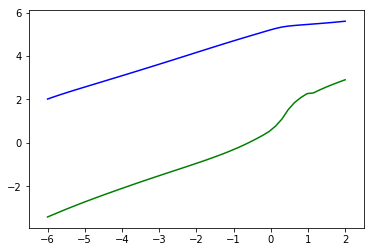

In [2]:
    
#Inspect initial guess
pylab.title = "Pressure structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "log_10 Pgas, Pe (dyne/cm^2)"
pylab.xlim(-6.5, 2.5)
yMin = min(log10guessPe) -0.5
yMax = max(log10guessPgas) + 0.5
pylab.ylim(yMin, yMax)

pylab.plot(log10tauRos, log10guessPgas, color='blue')
pylab.plot(log10tauRos, log10guessPe, color='green', linestyle='-')

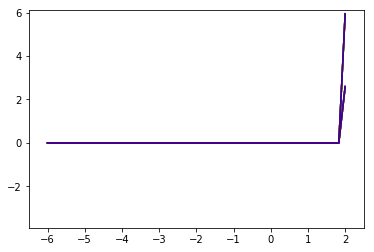

In [3]:
#
###################################################################
#
#
#
#   Converge atmospheric structure 
#
#    - Includes *initial* ionization equilibrium *without* molecules (for now)
#
#
#
###################################################################

#Initial pylab plot set-up
pylab.title = "Pressure structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "log_10 Pgas, Pe (dyne/cm^2)"
pylab.xlim(-6.5, 2.5)
yMax = max(log10guessPgas) + 0.5
yMin = min(log10guessPe) - 0.5
pylab.ylim(yMin, yMax)

log10temp = [0.0 for i in range(numDeps)]
log10pgas = [0.0 for i in range(numDeps)]
log10pe = [0.0 for i in range(numDeps)]
log10prad = [0.0 for i in range(numDeps)]
log10ne = [0.0 for i in range(numDeps)]
log10rho = [0.0 for i in range(numDeps)]
log10kappaRos = [0.0 for i in range(numDeps)]
log10kappa500 = [0.0 for i in range(numDeps)]
mmwAmu = [0.0 for i in range(numDeps)]
depthsKm = [0.0 for i in range(numDeps)]
#log10mmw = [0.0 for i in range(numDeps)]
#//
#// *********************
#//Jul 2016: Replace the following procedure for model building with the following PSEUDOCODE:
#//
#// 1st guess Tk(tau), Pe(tau), Pg(tau) from rescaling reference hot or cool model above
#// 1) Converge Pg-Pe relation for Az abundance distribution and  T_Kin(Tau)
#//   assuming all free e^-s from single ionizations - *inner* convergence
#// 2) Compute N_H from converged Pg-Pe relation 
#//    A_Tot = Sigma_z(A_z)
#//         -> N_H(tau) = (Pg(tau)-Pe(tau))/{kTk(tau)A_Tot}
#//         -> N_z(tau) = A_z * N_H(tau) 
#// 3) Obtain N_HI, N_HII, N_HeI, and N_HeII at all depths
#// 4)Get rho(tau) = Sigma_z(m_z*N_z(tau)) and mu(tau) = rho(tau) / N(tau)
#//    - needed for kappa in cm^2/g 
#// 5) kappa(tau) from Gray Ch. 8 sources - H, He, and e^- oapcity sources only
#// 6) P_Tot(tau) from HSE on tau scale with kappa from 4)
#//    - PRad(tau) from Tk(tau)
#//    - New Pg(tau) from P_Tot(tau)-PRad(tau)
#// 7) Iterate Pg - kappa relation to convergence - *outer* convergence
#// 8)Get rho(tau) = Sigma_z(m_z*N_z(tau)) and mu(tau) = rho(tau) / N(tau)
#//   and depth scale
#//
#//  ** Atmospheric structure converged **
#//
#// THEN for spectrum synthesis:
#//
#// 1) Separate iteration of Ne against ionization fractions fI(tau), fII, fIII, fIV, fV(tau) 
#// from Saha(Tk(tau), Pe(tau))
#//   AND coupled molecualr equilibrium 
#//    -  LevelPops.stagePops2() 
#// 2) new Ne(tau) from Sigma_z{fI(tau) .... 5*fV(tau) * N_z}
#// 3) Iterate
#// 4) Temp correction??   


#/    **** STOP ****  No - do we *really* need N_HI, ... for kappa if we use rho in HSE? - Yes - needed even if kappa
#//    is in cm^-1 instead of cm^2/g - sigh

species = " "  #; //default initialization
#  double rho[][] = new double[2][numDeps];
#  double[][] tauOneStagePops = new double[nelemAbnd][numStages];
rho = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
tauOneStagePops = [ [ 0.0 for i in range(numStages) ] for j in range(nelemAbnd) ]
unity = 1.0
zScaleList = 1.0 #//initialization   
#  double[][] log10UwAArr = new double[numStages][2];
log10UwAArr = [ [ 0.0 for i in range(2) ] for j in range(numStages)] 
for i in range(numStages):
    log10UwAArr[i][0] = 0.0 #//default initialization - logarithmic
    log10UwAArr[i][1] = 0.0 #//default initialization - logarithmic
  
 
#//Ground state ionization E - Stage I (eV) 
#  double[] chiIArr = new double[numStages]
chiIArr = [ 999999.0 for i in range(numStages) ]
#// //Ground state ionization E - Stage II (eV)
#//
#//For diatomic molecules:
speciesAB = " "
speciesA = " "
speciesB = " "
# double massA, massB, logMuAB;
# double[][] masterMolPops = new double[nMols][numDeps];
masterMolPops = [ [ 0.0 for i in range(numDeps) ] for j in range(nMols) ]
#//initialize masterMolPops for mass density (rho) calculation:
for i in range(nMols):
    for j in range(numDeps):
        masterMolPops[i][j] = -49.0  #//these are logarithmic
    
  
#//We will interpolate in atomic partition fns tabulated at two temperatures

thisUwAV = [ 0.0 for i in range(2) ]
thisUwBV = [ 0.0 for i in range(2) ]
#//We will interpolate in molecular partition fns tabulated at five temperatures
#  double thisDissE; 
thisQwAB = [ 0.0 for i in range(5) ]

#//
newNe = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
newPe = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
logNums = [ [ 0.0 for i in range(numDeps) ] for j in range(numStages) ]
#// For diatomic molecules:
logNumA = [ 0.0 for i in range(numDeps) ]
logNumB = [ 0.0 for i in range(numDeps) ]
logNumFracAB = [ 0.0 for i in range(numDeps) ]
#//

Ng = [ 0.0 for i in range(numDeps) ]
mmw = [ 0.0 for i in range(numDeps) ]
  #double logMmw;
logKappa = [ [ 0.0 for i in range(numDeps) ] for j in range(numLams) ]
logKappaHHe = [ [ 0.0 for i in range(numDeps) ] for j in range(numLams) ]
logKappaMetalBF = [ [ 0.0 for i in range(numDeps) ] for j in range(numLams) ]
logKappaRayl = [ [ 0.0 for i in range(numDeps) ] for j in range(numLams) ]
kappaRos = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
kappa500 = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
pGas = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
pRad = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
depths = [ 0.0 for i in range(numDeps) ]
newTemp = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]


#//Variables for ionization/molecular equilibrium treatment:
#//for diatomic molecules
logNumBArr = [ [ 0.0 for i in range(numDeps) ] for j in range(numAssocMols) ]
#//We will interpolate in atomic partition fns tabulated at two temperatures
log10UwBArr = [ [ 0.0 for i in range(2) ] for j in range(numAssocMols) ] #//base 10 log

dissEArr = [ 0.0 for i in range(numAssocMols) ]
#//We will interpolate in molecular partition fns tabulated at five temperatures
logQwABArr = [ [ 0.0 for i in range(5) ] for j in range(numAssocMols) ] #//natural log
logMuABArr = [ 0.0 for i in range(numAssocMols) ]

#// Arrays ofpointers into master molecule and element lists:
mname_ptr = [ 0 for i in range(numAssocMols) ]
specB_ptr = [ 0 for i in range(numAssocMols) ]
specA_ptr = 0
specB2_ptr = 0
mnameBtemplate = " "

#//
#//
#//We converge the Pgas - Pe relation first under the assumption that all free e^-s are from single ionizations
#// a la David Gray Ch. 9.  
#// This approach separates converging ionization fractions and Ne for spectrum synthesis purposes from
#// converging the Pgas-Pe-N_H-N_He relation for computing the mean opacity for HSE
#//
thisTemp = [ 0.0 for i in range(2) ]
log10UwUArr = [ 0.0 for i in range(2) ]
log10UwLArr = [ 0.0 for i in range(2) ]
#double chiI, peNumerator, peDenominator, logPhi, logPhiOverPe, logOnePlusPhiOverPe, logPeNumerTerm, logPeDenomTerm;

#//Begin Pgas-kapp iteration
for pIter in range(nOuterIter):
#//

#//  Converge Pg-Pe relation starting from intital guesses at Pg and Pe
#//  - assumes all free electrons are from single ionizations
#//  - David Gray 3rd Ed. Eq. 9.8:

    for neIter in range(nInnerIter):
        #//System.out.println("iD    logE*newPe[1][iD]     logE*guessPe[1]     logE*guessPGas[1]");
        for iD in range(numDeps):
        #//re-initialize accumulators:
            thisTemp[0] = temp[0][iD]
            thisTemp[1] = temp[1][iD]
            peNumerator = 0.0 
            peDenominator = 0.0
            for iElem in range(nelemAbnd):
                species = cname[iElem] + "I"
                chiI = IonizationEnergy.getIonE(species)
                #//THe following is a 2-element vector of temperature-dependent partitio fns, U, 
                #// that are base 10 log_10 U
                log10UwLArr = PartitionFn.getPartFn(species) #//base 10 log_10 U
                species = cname[iElem] + "II"
                log10UwUArr = PartitionFn.getPartFn(species) #//base 10 log_10 U
                logPhi = LevelPopsServer.sahaRHS(chiI, log10UwUArr, log10UwLArr, thisTemp)
                logPhiOverPe = logPhi - guessPe[1][iD]
                logOnePlusPhiOverPe = math.log(1.0 + math.exp(logPhiOverPe)) 
                logPeNumerTerm = logAz[iElem] + logPhiOverPe - logOnePlusPhiOverPe
                peNumerator = peNumerator + math.exp(logPeNumerTerm)
                logPeDenomTerm = logAz[iElem] + math.log(1.0 + math.exp(logPeNumerTerm))
                peDenominator = peDenominator + math.exp(logPeDenomTerm)
            #//iElem chemical element loop
            newPe[1][iD] = guessPGas[1][iD] + math.log(peNumerator) - math.log(peDenominator) 
            guessPe[1][iD] = newPe[1][iD]
            guessPe[0][iD] = math.exp(guessPe[1][iD])
        #//iD depth loop

    #//end Pg_Pe iteration neIter
    for iD in range(numDeps):
        newNe[1][iD] = newPe[1][iD] - temp[1][iD] - Useful.logK()
        newNe[0][iD] = math.exp(newNe[1][iD])
        guessNe[1][iD] = newNe[1][iD]
        guessNe[0][iD] = newNe[0][iD]
    
#//
#//Refine the number densities of the chemical elements at all depths  
    logNz = State.getNz(numDeps, temp, guessPGas, guessPe, ATot, nelemAbnd, logAz)
    for i in range(numDeps): 
        logNH[i] = logNz[0][i]
        #//System.out.println("i " + i + " logNH[i] " + logE*logNH[i]); 

#//
#//  Compute ionization fractions of H & He for kappa calculation 
#//
#//  Default inializations:
    zScaleList = 1.0 #//initialization   
    #//these 2-element temperature-dependent partition fns are logarithmic  

#//Default initialization:
    for i in range(numAssocMols):
        for j in range(numDeps):
            logNumBArr[i][j] = -49.0
           
        log10UwBArr[i][0] = 0.0
        log10UwBArr[i][1] = 0.0
        dissEArr[i] = 29.0  #//eV
        for kk in range(5): 
            logQwABArr[i][kk] = math.log(300.0)
           
        logMuABArr[i] = math.log(2.0) + Useful.logAmu()  #//g
        mname_ptr[i] = 0
        specB_ptr[i] = 0
       

    defaultQwAB = math.log(300.0) #//for now
    #//default that applies to most cases - neutral stage (I) forms molecules
    specBStage = 0 #//default that applies to most cases

    #//For element A of main molecule being treated in *molecular* equilibrium:
    #//For safety, assign default values where possible
    nmrtrDissE = 15.0 #//prohitively high by default
    nmrtrLog10UwB = [ 0.0 for i in range(2) ]
    nmrtrLog10UwB[0] = 0.0
    nmrtrLog10UwB[1] = 0.0
    nmrtrLog10UwA = 0.0
    nmrtrLogQwAB = [ 0.0 for i in range(5) ]
    for kk in range(5):
        nmrtrLogQwAB[kk] = math.log(300.0)
       
    nmrtrLogMuAB = Useful.logAmu()
    nmrtrLogNumB = [ 0.0 for i in range(numDeps) ]
    for i in range(numDeps):
        nmrtrLogNumB[i] = 0.0
       

    #double totalIonic;
    logGroundRatio = [ 0.0 for i in range(numDeps) ]

#//
#////H & He only for now... we only compute H, He, and e^- opacity sources: 
#   //for (int iElem = 0; iElem < 2; iElem++){
#//H to Fe only for now... we only compute opacity sources for elements up to Fe: 
    for iElem in range(26):
        species = cname[iElem] + "I"
        chiIArr[0] = IonizationEnergy.getIonE(species)
        #//THe following is a 2-element vector of temperature-dependent partitio fns, U, 
        #// that are base 10 log_10 U
        log10UwAArr[0] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "II"
        chiIArr[1] = IonizationEnergy.getIonE(species)
        log10UwAArr[1] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "III"
        chiIArr[2] = IonizationEnergy.getIonE(species)
        log10UwAArr[2] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "IV"
        chiIArr[3] = IonizationEnergy.getIonE(species)
        log10UwAArr[3] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "V"
        chiIArr[4] = IonizationEnergy.getIonE(species)
        log10UwAArr[4] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "VI"
        chiIArr[5] = IonizationEnergy.getIonE(species)
        log10UwAArr[5] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        #//double logN = (eheu[iElem] - 12.0) + logNH;

        thisNumMols = 0 #//default initialization
        for iMol in range(numAssocMols):
            #//console.log("iMol " + iMol + " cnameMols " + cnameMols[iElem][iMol]);
            if (cnameMols[iElem][iMol] == "None"):
                break;
          
            thisNumMols+=1
#//FLAG!
 #Trying to account for mols in ionization eq destailizes everything.
        thisNumMols = 0      
        if (thisNumMols > 0):
            #//Find pointer to molecule in master mname list for each associated molecule:
            for iMol in range(thisNumMols):
                for jj in range(nMols):
                    if (cnameMols[iElem][iMol] == mname[jj]):
                        mname_ptr[iMol] = jj #//Found it!
                        break
             
                #//jj loop in master mnames list
            #//iMol loop in associated molecules
#//Now find pointer to atomic species B in master cname list for each associated molecule found in master mname list!
            for iMol in range(thisNumMols):
                for jj in range(nelemAbnd):
                    if (mnameB[mname_ptr[iMol]] == cname[jj]):
                        specB_ptr[iMol] = jj #//Found it!
                        break
             
                #//jj loop in master cnames list
            #//iMol loop in associated molecules

#//Now load arrays with molecular species AB and atomic species B data for method stagePops2()
            for iMol in range(thisNumMols):
                #//special fix for H^+_2:
                if (mnameB[mname_ptr[iMol]] == "H2+"):
                    specBStage = 1
                else:
                    specBStage = 0
         
                for iTau in range(numDeps):
                    #//console.log("iMol " + iMol + " iTau " + iTau + " specB_ptr[iMol] " + specB_ptr[iMol]);
                    #//Note: Here's one place where ionization equilibrium iteratively couples to molecular equilibrium!
                    logNumBArr[iMol][iTau] = masterStagePops[specB_ptr[iMol]][specBStage][iTau]
          
                dissEArr[iMol] = IonizationEnergy.getDissE(mname[mname_ptr[iMol]])
                species = cname[specB_ptr[iMol]] + "I" #//neutral stage
                log10UwBArr[iMol] = PartitionFn.getPartFn(species) #//base 10 log_10 U
                #//logQwABArr[iMol] = defaultQwAB;
                logQwABArr[iMol] = PartitionFn.getMolPartFn(mname[mname_ptr[iMol]])
                #//Compute the reduced mass, muAB, in g:
                massA = AtomicMass.getMass(cname[iElem])
                massB = AtomicMass.getMass(cname[specB_ptr[iMol]])
                logMuABArr[iMol] = math.log(massA) + math.log(massB) - math.log(massA + massB) + Useful.logAmu()
       
        #//if thisNumMols > 0 condition

        logNums = LevelPopsServer.stagePops2(logNz[iElem], guessNe, chiIArr, log10UwAArr,   \
                     thisNumMols, logNumBArr, dissEArr, log10UwBArr, logQwABArr, logMuABArr, \
                     numDeps, temp)

        for iStage in range(numStages):
            for iTau in range(numDeps):

                masterStagePops[iElem][iStage][iTau] = logNums[iStage][iTau]
                #//save ion stage populations at tau = 1:
            #//iTau loop
        #//iStage loop
    #//iElem loop

    #//Get mass density from chemical composition: 
    rho = State.massDensity2(numDeps, nelemAbnd, logNz, cname)

#//Total number density of gas particles: nuclear species + free electrons:
#//AND
# //Compute mean molecular weight, mmw ("mu"):
    for i in range(numDeps):
        Ng[i] = newNe[0][i] #//initialize accumulation with Ne 
    
    for i in range(numDeps):
        for j in range(nelemAbnd):
            Ng[i] =  Ng[i] + math.exp(logNz[j][i]) #//initialize accumulation 
      
        logMmw = rho[1][i] - math.log(Ng[i]) # // in g
        mmw[i] = math.exp(logMmw) 
    

#//H & He only for now... we only compute H, He, and e^- opacity sources: 
    logKappaHHe = Kappas.kappas2(numDeps, newPe, zScale, temp, rho,  \
                     numLams, lambdaScale, logAz[1],  \
                     masterStagePops[0][0], masterStagePops[0][1],  \
                     masterStagePops[1][0], masterStagePops[1][1], newNe,  \
                     teff, logTotalFudge)

#//Add in metal b-f opacity from adapted Moog routines:
    logKappaMetalBF = KappasMetal.masterMetal(numDeps, numLams, temp, lambdaScale, masterStagePops)
#//Add in Rayleigh scattering opacity from adapted Moog routines:
    logKappaRayl = KappasRayl.masterRayl(numDeps, numLams, temp, lambdaScale, masterStagePops, masterMolPops)

#//Convert metal b-f & Rayleigh scattering opacities to cm^2/g and sum up total opacities
    #double logKapMetalBF, logKapRayl, kapContTot;
    for iL in range(numLams):
        for iD in range(numDeps):
            logKapMetalBF = logKappaMetalBF[iL][iD] - rho[1][iD] 
            logKapRayl = logKappaRayl[iL][iD] - rho[1][iD] 
            kapContTot = math.exp(logKappaHHe[iL][iD]) + math.exp(logKapMetalBF) + math.exp(logKapRayl) 
            logKappa[iL][iD] = math.log(kapContTot)
          
    kappaRos = Kappas.kapRos(numDeps, numLams, lambdaScale, logKappa, temp); 

#//Extract the "kappa_500" monochroamtic continuum oapcity scale
#// - this means we'll try interpreting the prescribed tau grid (still called "tauRos")as the "tau500" scale
    it500 = ToolBox.lamPoint(numLams, lambdaScale, 500.0e-7)
    for i in range(numDeps):
        kappa500[1][i] = logKappa[it500][i]
        kappa500[0][i] = math.exp(kappa500[1][i])
      
    pGas = Hydrostat.hydroFormalSoln(numDeps, grav, tauRos, kappaRos, temp, guessPGas)
    pRad = Hydrostat.radPress(numDeps, temp)

#//Update Pgas guess for iteration:
    for iTau in range(numDeps):
#// Now we can update guessPGas:
        guessPGas[0][iTau] = pGas[0][iTau]
        guessPGas[1][iTau] = pGas[1][iTau]
        log10pgas[i] = log10e * pGas[1][i]
        log10pe[i] = log10e * (newNe[1][i] + Useful.logK() + temp[1][i])
        log10prad[i] = log10e * pRad[1][i]
        log10ne[i] = log10e * newNe[1][i]

    #Uncomment this block to inspect iteration-by-iteration convergence
    #Graphically inspect convergence:  Issue 'matplotlib qt5' in console before running code
    thisClr = palette[pIter%numClrs]
    pylab.plot(log10tauRos, log10pgas, color=thisClr)
    pylab.plot(log10tauRos, log10pe, color=thisClr, linestyle='-')
    #pylab.plot(tauRos[1][:], newNe[1][:], thisClr)

    #End optional iteration inspection block
    
#//end Pgas-kappa iteration, nOuter
    
#//diagnostic
#//   int tauKapPnt01 = ToolBox.tauPoint(numDeps, tauRos, 0.01);
#//   System.out.println("logTauRos " + logE*tauRos[1][tauKapPnt01] + " temp " + temp[0][tauKapPnt01] + " pGas " + logE*pGas[1][tauKapPnt01]);
#//   System.out.println("tau " + " temp " + " logPgas " + " logPe " + " logRho "); 
#//   for (int iD = 1; iD < numDeps; iD+=5){
#//       System.out.println(" " + tauRos[0][iD] + " " + temp[0][iD] + " " +  logE*pGas[1][iD] + " " + logE*newPe[1][iD] + " " + logE*rho[1][iD]); 
#//   }
#//   for (int iL = 0; iL < numLams; iL++){
#//       //System.out.println(" " + lambdaScale[iL] + " " + logE*logKappa[iL][tauKapPnt01]); 
#//       System.out.println(" " + lambdaScale[iL]); 
#//       for (int iD = 1; iD < numDeps; iD+=5){
#//           System.out.println(" " + logE*(logKappa[iL][iD]+rho[1][iD]));  //cm^-1
#//       }
#//   } 
#   //int tauKapPnt1 = ToolBox.tauPoint(numDeps, tauRos, 1.0);
#   //System.out.println("logTauRos " + logE*tauRos[1][tauKapPnt1] + " temp " + temp[0][tauKapPnt1] + " pGas " + logE*pGas[1][tauKapPnt1]);
#   //for (int iL = 0; iL < numLams; iL++){
#   //    //System.out.println(" " + lambdaScale[iL] + " " + logE*logKappa[iL][tauKapPnt1]); 
#   //} 

 #       // Then construct geometric depth scale from tau, kappa and rho
depths = DepthScale.depthScale(numDeps, tauRos, kappaRos, rho)

ifTcorr = False
ifConvec = False
#//int numTCorr = 10;  //test
numTCorr = 0
for i in range(numTCorr):
    #//newTemp = TCorr.tCorr(numDeps, tauRos, temp);
    newTemp = MulGrayTCorr.mgTCorr(numDeps, teff, tauRos, temp, rho, kappaRos)
    #//newTemp = MulGrayTCorr.mgTCorr(numDeps, teff, tauRos, temp, rho, kappa500);
    for iTau in range(numDeps):
        temp[1][iTau] = newTemp[1][iTau]
        temp[0][iTau] = newTemp[0][iTau]
            
 
"""/*
     //Convection:
     // Teff below which stars are convective.  
     //  - has to be finessed because Convec.convec() does not work well :-(
     double convTeff = 6500.0;
     double[][] convTemp = new double[2][numDeps];
     if (teff < convTeff) {
     convTemp = Convec.convec(numDeps, tauRos, depths, temp, press, rho, kappaRos, kappaSun, zScale, teff, logg);
     for (int iTau = 0; iTau < numDeps; iTau++) {
     temp[1][iTau] = convTemp[1][iTau];
     temp[0][iTau] = convTemp[0][iTau];
      }
     }
     */
"""
 

#if ((ifTcorr == True) or (ifConvec == True)):
    #//Recall hydrostat with updates temps            
    #//Recall state withupdated Press                    
    #//recall kappas withupdates rhos
    #//Recall depths with re-updated kappas

#Atmospheric structure output: 
#Convert everything to log_10 OR re-scaled units for plotting, printing, etc:
    

for i in range(numDeps):
    log10temp[i] = log10e * temp[1][i]
    log10pgas[i] = log10e * pGas[1][i]
    log10pe[i] = log10e * (newNe[1][i] + Useful.logK() + temp[1][i])
    log10prad[i] = log10e * pRad[1][i]
    log10ne[i] = log10e * newNe[1][i]
    log10rho[i] = log10e * rho[1][i]
    log10NH[i] = log10e * logNH[i]
    log10kappaRos[i] = log10e * kappaRos[1][i]
    log10kappa500[i] = log10e * kappa500[1][i]
    mmwAmu[i] = mmw[i] / Useful.amu()
    depthsKm[i] = 1.0e-5 * depths[i]


outFile = outPath + strucFile
#print vertical atmospheric structure
with open(outFile, 'w', encoding='utf-8') as strucHandle:
#with open(strucFile, 'w') as strucHandle:    
    strucHandle.write(inputParamString + "\n")
    strucHandle.write("cgs units, unless otherwise noted" + "\n")
    strucHandle.write("logTauRos depth temp logPgas logPe logPRad logNe logNH logRho mu(amu) logKapRos logKap500" + "\n")
    for i in range(numDeps):
        outLine = str(log10tauRos[i]) + " " + str(depthsKm[i]) + " " + str(temp[0][i]) + " " + str(log10pgas[i]) + " " + str(log10pe[i]) +   \
                      " " + str(log10prad[i]) + " " + str(log10ne[i]) + " " + str(log10NH[i]) + " " + str(log10rho[i]) + " " + str(mmwAmu[i]) +   \
                      str(log10kappaRos[i]) + " " + str(log10kappa500[i]) + "\n"
        strucHandle.write(outLine)

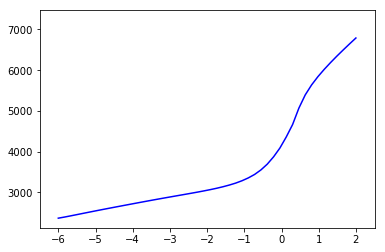

In [4]:
pylab.title = "Temperature structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "Tkin (K)"
pylab.xlim(-6.5, 2.5)
yMax = 1.1 * max(temp[0])
yMin = 0.9 * min(temp[0])
pylab.ylim(yMin, yMax)

#Final result
pylab.plot(log10tauRos, temp[0], color='blue')

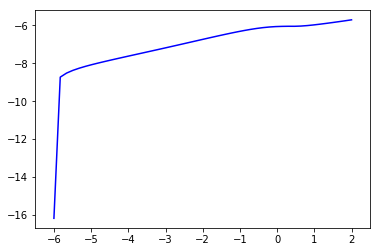

In [5]:
pylab.title = "Density structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "log_10 rho (g cm^-3)"
pylab.xlim(-6.5, 2.5)
yMax = max(log10rho) + 0.5
yMin = min(log10rho) - 0.5
pylab.ylim(yMin, yMax)

#Final result
pylab.plot(log10tauRos, log10rho, color='blue')

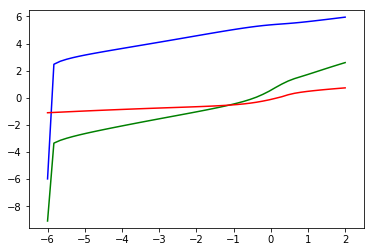

In [6]:
pylab.title = "Pressure structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "log_10 Pgas, Pe (dyne/cm^2)"
pylab.xlim(-6.5, 2.5)
yMax = max(log10pgas) + 0.5
yMin = min(log10pe) - 0.5
pylab.ylim(yMin, yMax)

pylab.plot(log10tauRos, log10pgas, color='blue')
pylab.plot(log10tauRos, log10pe, color='green', linestyle='-')
pylab.plot(log10tauRos, log10prad, color='red')

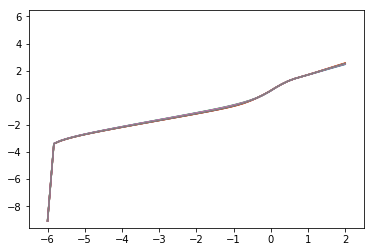

In [7]:
###################################################
#
#
#
# Re-converge Ionization/chemical equilibrium WITH molecules
#
#
#
####################################################

#Initial pylab plot set-up
pylab.title = "Pressure structure"
pylab.xlabel = "log_10 Tau_Ros"
pylab.ylabel = "log_10 Pgas, Pe (dyne/cm^2)"
pylab.xlim(-6.5, 2.5)
yMax = max(log10pgas) + 0.5
yMin = min(log10pe) - 0.5
pylab.ylim(yMin, yMax)

#//
#// Now that the atmospheric structure is settled: 
#// Separately converge the Ne-ionization-fractions-molecular equilibrium for
#// all elements and populate the ionization stages of all the species for spectrum synthesis:
#//
#//stuff to save ion stage pops at tau=1:
iTauOne = ToolBox.tauPoint(numDeps, tauRos, unity)

#//
#//  Default inializations:
zScaleList = 1.0 #/initialization
#//these 2-element temperature-dependent partition fns are logarithmic
    
#//Default initialization:
for i in range(numAssocMols):
    for j in range(numDeps):
        logNumBArr[i][j] = -49.0
           
    log10UwBArr[i][0] = 0.0
    log10UwBArr[i][1] = 0.0
    dissEArr[i] = 29.0  #//eV
    for kk in range(5):
        logQwABArr[i][kk] = math.log(300.0)
           
    logMuABArr[i] = math.log(2.0) + Useful.logAmu()  #//g
    mname_ptr[i] = 0
    specB_ptr[i] = 0
       

defaultQwAB = math.log(300.0) #//for now
    
#//default that applies to most cases - neutral stage (I) forms molecules
specBStage = 0 #//default that applies to most cases

#//For element A of main molecule being treated in *molecular* equilibrium:
#//For safety, assign default values where possible
nmrtrDissE = 15.0 #//prohitively high by default
nmrtrLog10UwB = [0.0 for i in range(2)]
nmrtrLog10UwB[0] = 0.0
nmrtrLog10UwB[1] = 0.0
nmrtrLog10UwA = 0.0
nmrtrLogQwAB = [0.0 for i in range(5)]
for kk in range(5):
    nmrtrLogQwAB[kk] = math.log(300.0)
       
nmrtrLogMuAB = Useful.logAmu()
nmrtrLogNumB = [0.0 for i in range(numDeps)]
for i in range(numDeps):
    nmrtrLogNumB[i] = 0.0

#double totalIonic;
logGroundRatio = [0.0 for i in range(numDeps)]


#//Iterate the electron densities, ionization fractions, and molecular densities:
#//
# //for (int neIter2 = 0; neIter2 < 5; neIter2++){   
for neIter2 in range(nInnerIter):
    
    for iElem in range(nelemAbnd):

        species = cname[iElem] + "I"
        chiIArr[0] = IonizationEnergy.getIonE(species)
        #//The following is a 2-element vector of temperature-dependent partitio fns, U,
        #// that are base 10 log_10 U
        log10UwAArr[0] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "II"
        chiIArr[1] = IonizationEnergy.getIonE(species)
        log10UwAArr[1] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "III"
        chiIArr[2] = IonizationEnergy.getIonE(species)
        log10UwAArr[2] = PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "IV"
        chiIArr[3] = IonizationEnergy.getIonE(species)
        log10UwAArr[3]= PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "V"
        chiIArr[4] = IonizationEnergy.getIonE(species)
        log10UwAArr[4]= PartitionFn.getPartFn(species) #//base 10 log_10 U
        species = cname[iElem] + "VI"
        chiIArr[5] = IonizationEnergy.getIonE(species)
        log10UwAArr[5]= PartitionFn.getPartFn(species) #//base 10 log_10 U
    
        thisNumMols = 0 #//default initialization
        for iMol in range(numAssocMols):
            if (cnameMols[iElem][iMol] == "None"):
                break
          
            thisNumMols+=1
     
        if (thisNumMols > 0):
            #//Find pointer to molecule in master mname list for each associated molecule:
            for iMol in range(thisNumMols):
                for jj in range(nMols):
                    if (cnameMols[iElem][iMol] == mname[jj]):
                        mname_ptr[iMol] = jj #//Found it!
                        break
                    #end if
                #} #//jj loop in master mnames list
            #} #//iMol loop in associated molecules
#//Now find pointer to atomic species B in master cname list for each associated molecule found in master mname list!
            for iMol in range(thisNumMols):
                for jj in range(nelemAbnd):
                    if (mnameB[mname_ptr[iMol]] == cname[jj]):
                        specB_ptr[iMol] = jj #//Found it!
                        break
                    #} //endif
                #} //jj loop in master cnames list
            #} //iMol loop in associated molecules

#//Now load arrays with molecular species AB and atomic species B data for method stagePops2()
            for iMol in range(thisNumMols):
                #//special fix for H^+_2:
                if (mnameB[mname_ptr[iMol]] == "H2+"):
                    specBStage = 1
                else:
                    specBStage = 0
            
                for iTau in range(numDeps):
                    #//Note: Here's one place where ionization equilibrium iteratively couples to molecular equilibrium!
                    logNumBArr[iMol][iTau] = masterStagePops[specB_ptr[iMol]][specBStage][iTau]            

                dissEArr[iMol] = IonizationEnergy.getDissE(mname[mname_ptr[iMol]])
                species = cname[specB_ptr[iMol]] + "I" #//neutral stage
                log10UwBArr[iMol] = PartitionFn.getPartFn(species) #//base 10 log_10 U
                #//logQwABArr[iMol] = defaultQwAB
                logQwABArr[iMol] = PartitionFn.getMolPartFn(mname[mname_ptr[iMol]])
                #//Compute the reduced mass, muAB, in g:
                massA = AtomicMass.getMass(cname[iElem])
                massB = AtomicMass.getMass(cname[specB_ptr[iMol]])
                logMuABArr[iMol] = math.log(massA) + math.log(massB) - math.log(massA + massB) + Useful.logAmu()
            #}
        #} //if thisNumMols > 0 condition

        logNums = LevelPopsServer.stagePops2(logNz[iElem], guessNe, chiIArr, log10UwAArr, \
                  thisNumMols, logNumBArr, dissEArr, log10UwBArr, logQwABArr, logMuABArr, \
                  numDeps, temp);

        for iStage in range(numStages):
            for iTau in range(numDeps):
                masterStagePops[iElem][iStage][iTau] = logNums[iStage][iTau]
            #//save ion stage populations at tau = 1:
            #} //iTau loop
            tauOneStagePops[iElem][iStage] = logNums[iStage][iTauOne]
        #} //iStage loop

    #} //iElem loop
    
#// Compute all molecular populations:
#//
#// *** CAUTION: specB2_ptr refers to element B of main molecule being treated
#// specB_ptr[] is an array of pointers to element B of all molecules associated with
#// element A
#// mname_ptr[] is an array of pointers pointing to the molecules themselves that are
#// associated with element A
    log10UwA = [0.0 for i in range(2)]

    for iMol in range(nMols):

        #//Find elements A and B in master atomic element list:
        specA_ptr = 0
        specB2_ptr = 0
        for jj in range(nelemAbnd):
            if (mnameA[iMol] == cname[jj]):
                specA_ptr = jj
                break  #//found it!
       
#// Get its partition fn:
        species = cname[specA_ptr] + "I" #//neutral stage
        log10UwA = PartitionFn.getPartFn(species) #//base 10 log_10 U
        for jj in range(nelemAbnd):
            if (mnameB[iMol] == cname[jj]):
                specB2_ptr = jj
                break  #//found it!
       
#//We will solve for N_AB/N_A - neutral stage of species A (AI) will be kept on LHS of molecular Saha equations -
#// Therefore, we need ALL the molecules species A participates in - including the current molecule itself
#// - at this point, it's just like setting up the ionization equilibrium to account for molecules as above...
        thisNumMols = 0 #//default initialization
        for im in range(numAssocMols):
            #//console.log("iMol " + iMol + " cnameMols " + cnameMols[iElem][iMol]);
            if (cnameMols[specA_ptr][im] == "None"):
                break
            thisNumMols+=1
       
        if (thisNumMols > 0):
            #//Find pointer to molecule in master mname list for each associated molecule:
            for im in range(thisNumMols):
                for jj in range(nMols):
                    if (cnameMols[specA_ptr][im] == mname[jj]):
                        mname_ptr[im] = jj #//Found it!
                        break
                    #}
                #} //jj loop in master mnames list
            #} //im loop in associated molecules

            #//Now find pointer to atomic species B in master cname list for each associated molecule found in master mname list!
            for im in range(thisNumMols):
                mnameBtemplate = " " #//initialization
                #// "Species B" is whichever element is NOT species "A" in master molecule
                if (mnameB[mname_ptr[im]] == mnameA[iMol]):
                    #//get the *other* atom
                    mnameBtemplate = mnameA[mname_ptr[im]]
                else:
                    mnameBtemplate = mnameB[mname_ptr[im]]
                
                for jj in range(nelemAbnd):
                    if (mnameBtemplate == cname[jj]):
                        #//console.log("If condition met: jj " + jj + " cname[jj] " + cname[jj]);
                        specB_ptr[im] = jj #//Found it!
                        break
                    
                #//jj loop in master cnames list
            #//iMol loop in associated molecules

            #//Now load arrays with molecular species AB and atomic species B data for method molPops()
            for im in range(thisNumMols):
                #//special fix for H^+_2:
                if (mname[mname_ptr[im]] == "H2+"):
                    specBStage = 1
                else:
                    specBStage = 0
                
                for iTau in range(numDeps):
                    #//Note: Here's one place where ionization equilibrium iteratively couples to molecular equilibrium!
                    logNumBArr[im][iTau] = masterStagePops[specB_ptr[im]][specBStage][iTau]
                
                dissEArr[im] = IonizationEnergy.getDissE(mname[mname_ptr[im]])
                species = cname[specB_ptr[im]] + "I"
                log10UwBArr[im] = PartitionFn.getPartFn(species) #//base 10 log_10 U
                #//logQwABArr[im] = defaultQwAB;
                logQwABArr[im] = PartitionFn.getMolPartFn(mname[mname_ptr[im]])
                #//Compute the reduced mass, muAB, in g:
                massA = AtomicMass.getMass(cname[specA_ptr])
                massB = AtomicMass.getMass(cname[specB_ptr[im]])
                logMuABArr[im] = math.log(massA) + math.log(massB) - math.log(massA + massB) + Useful.logAmu()
                #// One of the species A-associated molecules will be the actual molecule, AB, for which we want
                #// the population - pick this out for the numerator in the master fraction:
                if (mname[mname_ptr[im]] == mname[iMol]):
                    nmrtrDissE = dissEArr[im]
                    nmrtrLog10UwB[0] = log10UwBArr[im][0]
                    nmrtrLog10UwB[1] = log10UwBArr[im][1]
                    for kk in range(5):
                        nmrtrLogQwAB[kk] = logQwABArr[im][kk]
                    
                    nmrtrLogMuAB = logMuABArr[im]
                    for iTau in range(numDeps):
                        nmrtrLogNumB[iTau] = logNumBArr[im][iTau]
                    #}
                #}
            #} //im loop
        #//
        #} //if thisNumMols > 0 condition
        #//Compute total population of particle in atomic ionic stages over number in ground ionization stage
        #//for master denominator so we don't have to re-compue it:
        for iTau in range(numDeps):
            #//initialization:
            totalIonic = 0.0
            for iStage in range(numStages):
                totalIonic = totalIonic + math.exp(masterStagePops[specA_ptr][iStage][iTau])
           
            logGroundRatio[iTau] = math.log(totalIonic) - masterStagePops[specA_ptr][0][iTau]
        #} //iTau loop
        logNumFracAB = LevelPopsServer.molPops(nmrtrLogNumB, nmrtrDissE, log10UwA, nmrtrLog10UwB, nmrtrLogQwAB, nmrtrLogMuAB, \
                     thisNumMols, logNumBArr, dissEArr, log10UwBArr, logQwABArr, logMuABArr, \
                     logGroundRatio, numDeps, temp)

        #//Load molecules into master molecular population array:
        for iTau in range(numDeps):
            masterMolPops[iMol][iTau] = logNz[specA_ptr][iTau] + logNumFracAB[iTau]
        #} //iTau loop
    #} //master iMol loop
    #//
    #//Compute updated Ne & Pe:
    #//initialize accumulation of electrons at all depths
    for iTau in range(numDeps):
        newNe[0][iTau] = 0.0
     
    for iTau in range(numDeps):
        for iElem in range(nelemAbnd):
            #//1 e^- per ion, #//2 e^- per ion
            newNe[0][iTau] = newNe[0][iTau]   \
            + math.exp(masterStagePops[iElem][1][iTau])  \
            + 2.0 * math.exp(masterStagePops[iElem][2][iTau])   
            #//+ 3.0 * Math.exp(masterStagePops[iElem][3][iTau])   #//3 e^- per ion
            #//+ 4.0 * Math.exp(masterStagePops[iElem][4][iTau]);  #//3 e^- per ion
        #}
        newNe[1][iTau] = math.log(newNe[0][iTau])
        #// Update guess for iteration:
        guessNe[0][iTau] = newNe[0][iTau]
        guessNe[1][iTau] = newNe[1][iTau] 

    #Uncomment this block to inspect iteration-by-iteration convergence
    #diagnostic plots:
    #Graphically inspect convergence:  Issue 'matplotlib qt5' in console before running code
    for i in range(numDeps):
        log10pe[i] = log10e * (newNe[1][i] + Useful.logK() + temp[1][i])
        log10ne[i] = log10e * newNe[1][i]
        
    thisClr = palette[neIter2%numClrs]
    pylab.plot(log10tauRos, log10pe)
    #pylab.plot(log10tauRos[1], log10ne)  
    #pylab.plot(log10tauRos[1], masterMolPops[0][:])

    #End iteration inspection plot block
    
#} //end Ne - ionzation fraction -molecular equilibrium iteration neIter2

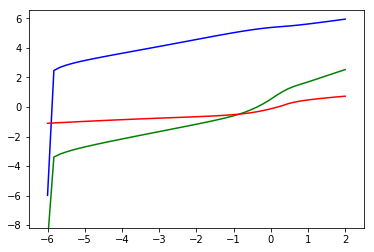

In [8]:
#Some atmospheric structure output AGAIN after chemical equilibrium: 
#Convert everything to log_10 OR re-scaled units for plotting, printing, etc:


#log10mmw = [0.0 for i in range(numDeps)]
for i in range(numDeps):
    log10pe[i] = log10e * (newNe[1][i] + Useful.logK() + temp[1][i])
    log10ne[i] = log10e * newNe[1][i]
    log10prad[i] = log10e * pRad[1][i]


outPath = absPath + "Outputs/"

outFile = outPath + struc2File
#print vertical atmospheric structure
with open(outFile, 'w', encoding='utf-8') as strucHandle:
#with open(strucFile, 'w') as strucHandle:    
    strucHandle.write(inputParamString + "\n")
    strucHandle.write("cgs units, unless otherwise noted" + "\n")
    strucHandle.write("logTauRos depth temp logPgas logPe logPRad logNe logNH logRho mu(amu) logKapRos logKap500" + "\n")
    for i in range(numDeps):
        outLine = str(log10tauRos[i]) + " " + str(depthsKm[i]) + " " + str(temp[0][i]) + " " + str(log10pgas[i]) + " " + str(log10pe[i]) +   \
                      " " + str(log10prad[i]) + " " + str(log10ne[i]) + " " + str(log10NH[i]) + " " + str(log10rho[i]) + " " + str(mmwAmu[i]) +   \
                      str(log10kappaRos[i]) + " " + str(log10kappa500[i]) + "\n"
        strucHandle.write(outLine)

#Final convergence
pylab.xlim(-6.5, 2.5)
yMax = 1.1 * max(log10pgas)
yMin = 0.9 * min(log10pe)
pylab.ylim(yMin, yMax)

pylab.plot(log10tauRos, log10pgas, color='blue')
pylab.plot(log10tauRos, log10pe, color='green', linestyle='-') 
pylab.plot(log10tauRos, log10prad, color='red')


In [9]:
############################################################
#
#
#
# Surface radiation field
#
#  - flux distribution (SED)
#  - high resolution synthetic spectrum
#
#
###############################################################

#//

#//Okay - Now all the emergent radiation stuff:
#// Set up theta grid
#//  cosTheta is a 2xnumThetas array:
#// row 0 is used for Gaussian quadrature weights
#// row 1 is used for cos(theta) values
#// Gaussian quadrature:
#// Number of angles, numThetas, will have to be determined after the fact
cosTheta = Thetas.thetas()
numThetas = len(cosTheta[0])

#//establish a phi grid for non-axi-symmetric situations (eg. spots, in situ rotation, ...)
#//    //number of phi values per quandrant of unit circle centered on sub-stellar point
#//        //    in plane of sky:
#//        //For geometry calculations: phi = 0 is direction of positive x-axis of right-handed
#//        // 2D Cartesian coord system in plane of sky with origin at sub-stellar point (phi
#//        // increases CCW)
numPhiPerQuad = 9
numPhi = 4 * numPhiPerQuad
numPhiD = float(numPhi)
phi = [0.0 for i in range(numPhi)]
#//Compute phi values in whole range (0 - 2pi radians):
delPhi = 2.0 * math.pi / numPhiD
#double ii
for i in range(numPhi):
    ii = float(i)
    phi[i] = delPhi * ii
    
    
#boolean lineMode;

#//
#// ************
#//
#//  Spectrum synthesis section:
#// Set up multi-Gray continuum info:
isCool = 7300.0  #//Class A0

#//Set up multi-gray opacity:
#// lambda break-points and gray levels:
#// No. multi-gray bins = num lambda breakpoints +1
minLambda = 30.0  #//nm
maxLambda = 1.0e6  #//nm

#// JOLA molecular bands here:
#// Just-overlapping line approximation treats molecular ro-vibrational bands as pseudo-continuum
#//opacity sources by "smearing" out the individual rotational fine-structure lines
#//See 1982A&A...113..173Z, Zeidler & Koester, 1982

#double jolaOmega0;  //band origin ?? //Hz OR waveno in cm^-1 ??
#//double[] jolaLogF; //total vibrational band oscillator strength (f_v'v")
#double jolaRSqu; //needed for total vibrational band oscillator strength (f_v'v")
jolaB = [0.0 for i in range(2)] #// B' value of upper vibational state (energy in cm^-1)??
jolaLambda = [0.0 for i in range(2)]
jolaAlphP = 0.0 #// alpha_P - weight of P branch (Delta J = -1)
jolaAlphR = 0.0 #/ alpha_R - weight of R branch (Delta J = 1)
jolaAlphQ = 0.0 #// alpha_Q - weight of Q branch (Delta J = 0)
#//Allen's Astrophysical quantities, 4th Ed., 4.12.2 - 4.13.1:
#// Electronic transition moment, Re
#//"Line strength", S = |R_e|^2*q_v'v" or just |R_e|^2 (R_00 is for the band head)
#//Section 4.4.2 - for atoms or molecules:
#// then: gf = (8pi^2m_e*nu/3he^2) * S
#//
#// ^48Ti^16O systems: Table 4.18, p. 91
#//  C^3Delta - X^3Delta ("alpha system") (Delta Lambda = 0??, p. 84 - no Q branch??)
#//  c^1Phi - a^1Delta ("beta system") (Delta Lambda = 1??, p. 84)
#//  A^3Phi - X^3Delta ("gamma system") (Delta Lambda = 0??, p. 84 - no Q branch??)
#// //
#// Rotational & vibrational constants for TiO states:, p. 87, Table 4.17
#// C^3Delta, X^3Delta a^1Delta, -- No "c^1Phi" - ??
#//
#//General TiO molecular rotational & vibrational constants - Table 3.12, p. 47

#//Zeidler & Koester 1982 p. 175, Sect vi):
#//If Q branch (deltaLambda = +/-1): alpP = alpR = 0.25, alpQ = 0.5
#//If NO Q branch (deltaLambda = 0): alpP = alpR = 0.5, alpQ = 0.0

#//number of wavelength point sampling a JOLA band
jolaNumPoints = 100 
#//int jolaNumPoints = 10; 

#// branch weights for transitions of DeltaLambda = +/- 1
jolaAlphP_DL1 = 0.25
jolaAlphR_DL1 = 0.25
jolaAlphQ_DL1 = 0.5
#// branch weights for transitions of DeltaLambda = 0
jolaAlphP_DL0 = 0.5
jolaAlphR_DL0 = 0.5
jolaAlphQ_DL0 = 0.0 #//no Q branch in this case

#double jolaS; //line strength
#double jolaLogF; //line strength

logSTofHelp = math.log(8.0/3.0) + 2.0*math.log(math.pi) + Useful.logMe() - Useful.logH() - 2.0*Useful.logEe()
#//Hand-tuned for now - Maybe this is the "script S" factor in Allen 4th Ed., p. 88 (S = |R|^2*q_v'v"*scriptS)
jolaQuantumS = 1.0 #//default for multiplicative factor 
logNumJola = [0.0 for i in range(numDeps)]
jolaProfPR = [ [0.0 for i in range(numDeps)] for j in range(jolaNumPoints) ]  #// For unified P & R branch
jolaProfQ = [ [0.0 for i in range(numDeps)] for j in range(jolaNumPoints) ]  #//For Q branch
#//Differential cross-section - the main "product" of the JOLA approximation:
dfBydv = [ [0.0 for i in range(numDeps)] for j in range(jolaNumPoints) ]  

#//
dataPath = "InputData/"
#//
#//
#// **************  Atomic line list:
#//
#//NIST Atomic Spectra Database Lines Data
#//Kramida, A., Ralchenko, Yu., Reader, J., and NIST ASD Team (2015). NIST Atomic Spectra Database (ver. 5.3), [Online]. Available: http://physics.nist.gov/asd [2017, January 30]. National Institute of Standards and Technology, Gaithersburg, MD.
#//
#//Stuff for byte file method:
#//
#// *** NOTE: bArrSize must have been noted from the stadout of LineListServer and be consistent
#// with whichever line list is linked to gsLineListBytes.dat, and be st manually here:
lineListBytes = absPath + dataPath + "atomLineListFeb2017Bytes.dat"
#lineListBytes = "gsLineListBytes.dat"
#//

#//System.out.println(" *********************************************** ");
#//System.out.println("  ");
#//System.out.println("  ");
print("BEFORE FILE READ")
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println(" *********************************************** ");

with open(lineListBytes, 'rb') as fHandle:    
    #Java: barray = ByteFileRead.readFileBytes(lineListBytes, bArrSize);
    barray = fHandle.read()
    
#fHandle closed automatically when with: exited   

#Java: String decoded = new String(barray, 0, bArrSize);  // example for one encoding type 
decoded = barray.decode('utf-8')

#//System.out.println(" *********************************************** ");
#//System.out.println("  ");
#//System.out.println("  ");
print("AFTER FILE READ")
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println(" *********************************************** ");

arrayLineString = decoded.split("%%")
#//Number of lines MUST be the ONLY entry on the first line 

numLineList = len(arrayLineString) - 1
#numLineList = 1 #//test


#//Atomic lines:
#//Okay, here we go:
list2Lam0 = [0.0 for i in range(numLineList)]  #// nm
list2Element = ["" for i in range(numLineList)] #//element
list2StageRoman = ["" for i in range(numLineList)] #//ion stage
list2Stage = [0 for i in range(numLineList)] #//ion stage
list2Mass = [0.0 for i in range(numLineList)] #// amu
list2LogGammaCol = [0.0 for i in range(numLineList)]
#//Einstein coefficient for spontaneous de-exciation:
list2LogAij = [0.0 for i in range(numLineList)] #//log base 10
#//Log of unitless oscillator strength, f 
list2Logf = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage I (eV) 
list2ChiI1 = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage II (eV)
list2ChiI2 = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage III (eV) 
list2ChiI3 = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage IV (eV)
list2ChiI4 = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage V (eV)
list2ChiI5 = [0.0 for i in range(numLineList)]
#//Ground state ionization E - Stage VI (eV)
list2ChiI6 = [0.0 for i in range(numLineList)]
#//Excitation E of lower E-level of b-b transition (eV)
list2ChiL = [0.0 for i in range(numLineList)]
#//Unitless statisital weight, Ground state - Stage I
#//double[] list2Gw1 = new double[numLineList];
#//Unitless statisital weight, Ground state - Stage II
#//double[] list2Gw2 = new double[numLineList];
#//Unitless statisital weight, Ground state - Stage III
#//double[] list2Gw3 = new double[numLineList];
#//Unitless statisital weight, Ground state - Stage IV
#//double[] list2Gw4 = new double[numLineList];
#//double[] list2Gw4 = new double[numLineList];
#//Unitless statisital weight, lower E-level of b-b transition                 
list2GwL = [0.0 for i in range(numLineList)]
#//double[] list2GwU For now we'll just set GwU to 1.0
#// Is stage II?

#//Atomic Data sources:
 
#double thisF;
list2_ptr = 0 #//pointer into line list2 that we're populating
numFields = 7 #//number of field per record 
#// 0: element, 1: ion stage, 2: lambda_0, 3: logf, 4: g_l, 5: chi_l
thisRecord = ["" for i in range(numFields)] 
    
#String myString;  //useful helper

for iLine in range(numLineList):

    
    #// "|" turns out to mean something in regexp, so we need to escape with '\\':
    thisRecord = arrayLineString[iLine].split("|")
    #//System.out.println("thisRecord[0] " + thisRecord[0]
    #//                 + "thisRecord[1] " + thisRecord[1] 
    #//                 + "thisRecord[2] " + thisRecord[2] 
    #//                 + "thisRecord[3] " + thisRecord[3] 
    #//                 + "thisRecord[4] " + thisRecord[4] 
    #//                 + "thisRecord[5] " + thisRecord[5]);
                 
       
    myString = thisRecord[0].strip() 
    list2Element[iLine] = myString
    myString = thisRecord[1].strip()
    list2StageRoman[iLine] = myString  
    myString = thisRecord[2].strip() 
    list2Lam0[iLine] = float(myString)
    myString = thisRecord[3].strip()
    list2LogAij[iLine] = float(myString)
    myString = thisRecord[4].strip()
    list2Logf[iLine] = float(myString)
    myString = thisRecord[5].strip()
    list2ChiL[iLine] = float(myString)
    #//// Currently not used
    #//        myString = thisRecord[6].trim();
    #//        list2ChiU = Double.parseDouble(myString);
    #//        myString = thisRecord[7].trim();
    #//        list2Jl = Double.parseDouble(myString);
    #//        myString = thisRecord[8].trim();
    #//        list2Ju = Double.parseDouble(myString);
    myString = thisRecord[9].strip()
    list2GwL[iLine] = float(myString)
    #//// Currently not used
    #//        myString = thisRecord[10].trim();
    #//        list2GwU = Double.parseDouble(myString);
        
    #//Get the chemical element symbol - we don't know if it's one or two characters
    if (list2StageRoman[list2_ptr] == "I"):
        list2Stage[list2_ptr] = 0
             
    if (list2StageRoman[list2_ptr] == "II"):
        list2Stage[list2_ptr] = 1
             
    if (list2StageRoman[list2_ptr] == "III"):
        list2Stage[list2_ptr] = 2
             
    if (list2StageRoman[list2_ptr] == "IV"):
        list2Stage[list2_ptr] = 3
             
    if (list2StageRoman[list2_ptr] == "V"):
        list2Stage[list2_ptr] = 4
             
    if (list2StageRoman[list2_ptr] == "VI"):
        list2Stage[list2_ptr] = 5
             
    if (list2StageRoman[list2_ptr] == "VII"):
        list2Stage[list2_ptr] = 6
             
#//wavelength in nm starts at position 23 and is in %8.3f format - we're not expecting anything greater than 9999.999 nm

#// Some more processing:
    list2Mass[list2_ptr] = AtomicMass.getMass(list2Element[list2_ptr])
    species = list2Element[list2_ptr] + "I"
    list2ChiI1[list2_ptr] = IonizationEnergy.getIonE(species) 
    species = list2Element[list2_ptr] + "II"
    list2ChiI2[list2_ptr] = IonizationEnergy.getIonE(species)
    species = list2Element[list2_ptr] + "III"
    list2ChiI3[list2_ptr] = IonizationEnergy.getIonE(species) 
    species = list2Element[list2_ptr] + "IV"
    list2ChiI4[list2_ptr] = IonizationEnergy.getIonE(species)
    species = list2Element[list2_ptr] + "V"
    list2ChiI5[list2_ptr] = IonizationEnergy.getIonE(species)
    species = list2Element[list2_ptr] + "VI"
    list2ChiI6[list2_ptr] = IonizationEnergy.getIonE(species)

    #//We're going to have to fake the ground state statistical weight for now - sorry:
    #//list2Gw1[list2_ptr] = 1.0;
    #//list2Gw2[list2_ptr] = 1.0; 
    #//list2Gw3[list2_ptr] = 1.0;
    #//list2Gw4[list2_ptr] = 1.0; 
    list2LogGammaCol[list2_ptr] = logGammaCol 

    #//We've gotten everything we need from the NIST line list:
    list2_ptr+=1
        
    #} //iLine loop 

numLines2 = list2_ptr
#numLines2 = 0  #test
#//
#
#//Okay - what kind of mess did we make...
#
#
#// END FILE I/O SECTION


#//System.out.println(" *********************************************** ");
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println("BEFORE TRIAGE");
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println(" *********************************************** ");
#//
#//Triage: For each line: Voigt, Gaussian, or neglect??

#//
gaussLineCntr = 0 #//initialize accumulator
#//int sedLineCntr = 0; //initialize accumulator
#//No! boolean[] ifThisLine = new boolean[numLines2]; //initialize line strength flag
gaussLine_ptr = [0 for i in range(numLines2)] #//array of pointers to lines that make the cut in the 
#//int sedLine_ptr[] = new int[numLines2]; //array of pointers to lines that make the cut in the 
                                                  #// master line list  
        
isFirstLine = True #//initialization
firstLine = 0 #//default initialization
#// This holds 2-element temperature-dependent base 10 logarithmic parition fn:
thisUwV = [0.0 for i in range(2)]
thisUwV[0] = 0.0 #//default initialization
thisUwV[1] = 0.0


for iLine in range(numLines2):

    #//No! ifThisLine[iLine] = false;
    #//if H or He, make sure kappaScale is unity:
    if ((list2Element[iLine] == "H") \
    or (list2Element[iLine] == "He")):
        zScaleList = 1.0
        #//list2Gw1[iLine] = 2.0;  //fix for H lines
        if (list2Lam0[iLine] <= 657.0):
            list2GwL[iLine] = 8.0  #//fix for Balmer lines
        else:
            list2GwL[iLine] = 18.0  #//fix for Paschen lines        
    else: 
        zScaleList = zScale


    list2Lam0[iLine] = list2Lam0[iLine] * nm2cm  #// nm to cm
    iAbnd = 0 #//initialization
    logNums_ptr = 0
    #//System.out.println("iLine " + iLine + " list2Element[iLine] " + list2Element[iLine]);
    for jj in range(nelemAbnd):
        #//System.out.println("jj " + jj + " cname[jj]" + cname[jj]+"!");
        if (list2Element[iLine] == cname[jj]):
            if (list2Stage[iLine] == 0):
                 species = cname[jj] + "I"
                 logNums_ptr = 0
            
            if (list2Stage[iLine] == 1):
                 species = cname[jj] + "II"
                 logNums_ptr = 1
            
            if (list2Stage[iLine] == 2):
                 species = cname[jj] + "III"
                 logNums_ptr = 4
            
            if (list2Stage[iLine] == 3):
                 species = cname[jj] + "IV"
                 logNums_ptr = 5
            
            if (list2Stage[iLine] == 4):
                 species = cname[jj] + "V"
                 logNums_ptr = 6
            
            if (list2Stage[iLine] == 5):
                 species = cname[jj] + "VI"
                 logNums_ptr = 7
            
            thisUwV = PartitionFn.getPartFn(species) #//base 10 log_10 U
            break   #//we found it
        
        iAbnd+=1
    #} //jj loop
            
    list2LogNums = [ [ 0.0 for i in range(numDeps) ] for j in range(numStages+2) ]
    for iTau in range(numDeps):
        list2LogNums[0][iTau] = masterStagePops[iAbnd][0][iTau]
        list2LogNums[1][iTau] = masterStagePops[iAbnd][1][iTau]
        list2LogNums[4][iTau] = masterStagePops[iAbnd][2][iTau]
        list2LogNums[5][iTau] = masterStagePops[iAbnd][3][iTau]
        list2LogNums[6][iTau] = masterStagePops[iAbnd][4][iTau]
        list2LogNums[7][iTau] = masterStagePops[iAbnd][5][iTau]
            
    numHelp = LevelPopsServer.levelPops(list2Lam0[iLine], list2LogNums[logNums_ptr], list2ChiL[iLine], thisUwV, \
                list2GwL[iLine], numDeps, temp)
    for iTau in range(numDeps):
        list2LogNums[2][iTau] = numHelp[iTau]
        list2LogNums[3][iTau] = numHelp[iTau] / 2.0 #//fake for testing with gS3 line treatment
            

    #//linePoints: Row 0 in cm (will need to be in nm for Plack.planck), Row 1 in Doppler widths
    #//For now - initial strength check with delta fn profiles at line centre for triage:
    listNumPointsDelta = 1
    listLinePointsDelta = LineGrid.lineGridDelta(list2Lam0[iLine], list2Mass[iLine], xiT, numDeps, teff)
    listLineProfDelta = LineProf.delta(listLinePointsDelta, list2Lam0[iLine], numDeps, tauRos, list2Mass[iLine], xiT, teff) 
    listLogKappaLDelta = LineKappa.lineKap(list2Lam0[iLine], list2LogNums[2], list2Logf[iLine], listLinePointsDelta, listLineProfDelta,
                    numDeps, zScaleList, tauRos, temp, rho)
    
    """/* Let's not do this - too slow:
            // Low resolution SED lines and high res spectrum synthesis region lines are mutually
            // exclusive sets in wavelength space:
            //Does line qualify for inclusion in SED as low res line at all??
            // Check ratio of line centre opacity to continuum at log(TauRos) = -5, -3, -1
            if ( (logE*(listLogKappaLDelta[0][6] - kappa[1][6]) > sedThresh)  
              || (logE*(listLogKappaLDelta[0][18] - kappa[1][18]) > sedThresh)  
              || (logE*(listLogKappaLDelta[0][30] - kappa[1][30]) > sedThresh) ){ 
                   if ( ( list2Stage[iLine] == 0) || (list2Stage[iLine] == 1) 
                    ||  ( list2Stage[iLine] == 2) || (list2Stage[iLine] == 3) ){
                        if ( (list2Lam0[iLine] > lamUV) && (list2Lam0[iLine] < lamIR) ){
                           if ( (list2Lam0[iLine] < lambdaStart) || (list2Lam0[iLine] > lambdaStop) ){ 
                      //No! ifThisLine[iLine] = true;
                      sedLine_ptr[sedLineCntr] = iLine;
                      sedLineCntr++;
      //System.out.println("SED passed, iLine= " + iLine + " sedLineCntr " + sedLineCntr 
      //   + " list2Lam0[iLine] " + list2Lam0[iLine] 
      //   + " list2Element[iLine] " + list2Element[iLine]
      //   + " list2Stage[iLine] " + list2Stage[iLine]); 
                                 }
                            }
                      } 
                }
    */
    """

    #//Does line qualify for inclusion in high res spectrum synthesis region??
    #// Check ratio of line centre opacity to continuum at log(TauRos) = -5, -3, -1
    #//Find local value of lambda-dependent continuum kappa - list2Lam0 & lambdaScale both in cm here: 
    thisLambdaPtr = ToolBox.lamPoint(numLams, lambdaScale, list2Lam0[iLine])
    if ( (logE*(listLogKappaLDelta[0][6] - logKappa[thisLambdaPtr][6]) > lineThresh)  
    or (logE*(listLogKappaLDelta[0][18] - logKappa[thisLambdaPtr][18]) > lineThresh)  
    or (logE*(listLogKappaLDelta[0][30] - logKappa[thisLambdaPtr][30]) > lineThresh) ): 
        if ( ( list2Stage[iLine] == 0) or (list2Stage[iLine] == 1) 
		  or ( list2Stage[iLine] == 2) or (list2Stage[iLine] == 3) 
        or  ( list2Stage[iLine] == 4) or (list2Stage[iLine] == 5) ):
            if ( (list2Lam0[iLine] > lambdaStart) and (list2Lam0[iLine] < lambdaStop) ): 
                #special test condition
                #if (list2Element[iLine] == "Na"):
			           #//No! ifThisLine[iLine] = true;
                    gaussLine_ptr[gaussLineCntr] = iLine
                    gaussLineCntr+=1
                    if (isFirstLine == True):
                        firstLine = iLine
                        isFirstLine = False

#//
#} //iLine loop

#//
#
#//We need to have at least one line in region:
areNoLines = False #//initialization
if (gaussLineCntr == 0):
    gaussLineCntr = 1
    gaussLine_ptr[0] = firstLine
    areNoLines = True
         

numGaussLines = gaussLineCntr
#//System.out.println(" *********************************************** ");
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println("AFTER TRIAGE");
#//System.out.println("  ");
#//System.out.println("  ");
#//System.out.println(" *********************************************** ");

#//Notes
#//if Hydrogen or Helium, kappaScale should be unity for these purposes:
#//double kappaScaleList = 1.0; //initialization                   
#//

listNumCore = 3  #//half-core //default initialization
listNumWing = 1  #//per wing
#//int sedNumWing = 1;  //per wing
#//int thisNumCore = sedNumCore; //default initialization
#//int thisNumWing = sedNumWing; //default initialization
if (sampling == "coarse"):
    listNumCore = 3  #//half-core
    listNumWing = 3  #//per wing
else: 
    listNumCore = 5  #//half-core
    listNumWing = 9  #//per wing
         
#//Delta fn - for testing and strength triage
#        //int listNumPoints = 1;
#//All gaussian
#        //int listNumPoints = 2 * listNumCore - 1; // + 1;  //Extra wavelength point at end for monochromatic continuum tau scale
#////All full voigt:
listNumPoints = (2 * (listNumCore + listNumWing) - 1) #// + 1;  //Extra wavelength point at end for monochromatic continuum tau scale
#//int sedNumPoints = (2 * (sedNumCore + sedNumWing) - 1); // + 1;  //Extra wavelength point at end for monochromatic continuum tau scale
#//int thisNumPoints = sedNumPoints; //default initialization
numNow = numLams  #//initialize dynamic counter of how many array elements are in use
#int numMaster;
if (ifTiO == 1):
    numMaster = numLams + (numGaussLines * listNumPoints) + (numJola * jolaNumPoints) #// + (numSedLines * sedNumPoints); //total size (number of wavelengths) of master lambda & total kappa arrays 
else:
    numMaster = numLams + (numGaussLines * listNumPoints)
    
masterLams = [0.0 for i in range(numMaster)]
#//Line blanketed opacity array:

logMasterKaps = [ [ 0.0 for i in range(numDeps) ] for j in range(numMaster) ]
#//seed masterLams and logMasterKaps with continuum SED lambdas and kappas:
#//This just initializes the first numLams of the numMaster elements

#//Initialize monochromatic line blanketed opacity array:
#// Seed first numLams wavelengths with continuum wavelength and kappa values 
for iL in range(numLams):
    masterLams[iL] = lambdaScale[iL]
    for iD in range(numDeps):
        logMasterKaps[iL][iD] = logKappa[iL][iD] 
            
        
#//initialize the remainder with dummy values - these values will be clobbered as line wavelengths are inserted, 
#// and don't matter
for iL in range(numLams, numMaster):
    masterLams[iL] = lambdaScale[numLams - 1]
    for iD in range(numDeps):
        logMasterKaps[iL][iD] = logKappa[numLams-1][iD]
            

#//Stuff for the the Teff recovery test:
#double lambda1, lambda2, fluxSurfBol, logFluxSurfBol;
fluxSurfBol = 0
 
#//Get the components for the power series expansion approximation of the Hjerting function
#//for treating Voigt profiles:
hjertComp = HjertingComponents.hjertingComponents()

#// This holds 2-element temperature-dependent base 10 logarithmic parition fn:
thisUwV[0] = 0.0 #//default initialization
thisUwV[1] = 0.0

listLineProf = [ [ 0.0 for i in range(numDeps) ] for j in range(listNumPoints) ]

print("Beginning spectrum synthesis, numVoigtLines ", numGaussLines)
#// Put in high res spectrum synthesis lines:
for iLine in range(numGaussLines):

    #//if H or He, make sure kappaScale is unity:
    if ((list2Element[gaussLine_ptr[iLine]] == "H")
    or (list2Element[gaussLine_ptr[iLine]] == "He")):
        zScaleList = 1.0
        #//list2Gw1[gaussLine_ptr[iLine]] = 2.0;  //fix for H lines
        if (list2Lam0[gaussLine_ptr[iLine]] <= 657.0e-7):
            list2GwL[gaussLine_ptr[iLine]] = 8.0  #//fix for Balmer lines
        else:
            list2GwL[gaussLine_ptr[iLine]] = 18.0  #//fix for Paschen lines
    else:
        zScaleList = zScale;
    

    #//
    iAbnd = 0 #//initialization
    logNums_ptr = 0
    for jj in range(nelemAbnd):
        if (list2Element[gaussLine_ptr[iLine]] == cname[jj]):
            if (list2Stage[gaussLine_ptr[iLine]] == 0):
                species = cname[jj] + "I"
                logNums_ptr = 0
                
            if (list2Stage[gaussLine_ptr[iLine]] == 1):
                species = cname[jj] + "II"
                logNums_ptr = 1
                
            if (list2Stage[gaussLine_ptr[iLine]] == 2):
                species = cname[jj] + "III"
                logNums_ptr = 4
                
            if (list2Stage[gaussLine_ptr[iLine]] == 3):
                species = cname[jj] + "IV"
                logNums_ptr = 5
                
            if (list2Stage[gaussLine_ptr[iLine]] == 4):
                species = cname[jj] + "V"
                logNums_ptr = 6
                
            if (list2Stage[gaussLine_ptr[iLine]] == 5):
                species = cname[jj] + "VI"
                logNums_ptr = 7
                
            thisUwV = PartitionFn.getPartFn(species) #//base 10 log_10 U
            break   #//we found it
             #}
        iAbnd+=1
    #} //jj loop
        
    list2LogNums = [ [ 0.0 for i in range(numDeps) ] for j in range(numStages+2) ]
    for iTau in range(numDeps):
        list2LogNums[0][iTau] = masterStagePops[iAbnd][0][iTau]
        list2LogNums[1][iTau] = masterStagePops[iAbnd][1][iTau]
        list2LogNums[4][iTau] = masterStagePops[iAbnd][2][iTau]
        list2LogNums[5][iTau] = masterStagePops[iAbnd][3][iTau]
        list2LogNums[6][iTau] = masterStagePops[iAbnd][4][iTau]
        list2LogNums[7][iTau] = masterStagePops[iAbnd][5][iTau]
            
    numHelp = LevelPopsServer.levelPops(list2Lam0[gaussLine_ptr[iLine]], list2LogNums[logNums_ptr], list2ChiL[gaussLine_ptr[iLine]], thisUwV,
                    list2GwL[gaussLine_ptr[iLine]], numDeps, temp)
    for iTau in range(numDeps):
        list2LogNums[2][iTau] = numHelp[iTau]
        list2LogNums[3][iTau] = -19.0 #//upper E-level - not used - fake for testing with gS3 line treatment
        #if ( (list2Element[gaussLine_ptr[iLine]] == "Na") and (list2Stage[gaussLine_ptr[iLine]] == 0) ):
            #if (iTau%5 == 1):
            #    outline = ("iTau "+ str(iTau)+ " Na I list2LogNums[2]: "+ str(log10e*list2LogNums[2][iTau]) + "\n")
            #    outHandle.write(outline)

    #//Proceed only if line strong enough: 
    #// 
    #//ifThisLine[gaussLine_ptr[iLine]] = true; //for testing
    #//No! if (ifThisLine[gaussLine_ptr[iLine]] == true){
              
    #// Gaussian only approximation to profile (voigt()):
    #//            double[][] listLinePoints = LineGrid.lineGridGauss(list2Lam0[gaussLine_ptr[iLine]], list2Mass[gaussLine_ptr[iLine]], xiT, numDeps, teff, listNumCore);
    #//            double[][] listLineProf = LineProf.gauss(listLinePoints, list2Lam0[gaussLine_ptr[iLine]],
    #//                    numDeps, teff, tauRos, temp, tempSun);
    #// Gaussian + Lorentzian approximation to profile (voigt()):
    listLinePoints = LineGrid.lineGridVoigt(list2Lam0[gaussLine_ptr[iLine]], list2Mass[gaussLine_ptr[iLine]], xiT, 
                                            numDeps, teff, listNumCore, listNumWing)
    #print("species: ", species)
    #if ( (list2Element[gaussLine_ptr[iLine]] == "Na") and (list2Stage[gaussLine_ptr[iLine]] == 0) ):
    #    outline = ("iLine "+ str(iLine)+ " gaussLine_ptr "+ str(gaussLine_ptr[iLine])+ " list2Lam0 "+ str(list2Lam0[gaussLine_ptr[iLine]])+ " list2LogAij "+ 
    #      str(list2LogAij[gaussLine_ptr[iLine]])+ " list2LogGammaCol "+ str(list2LogGammaCol[gaussLine_ptr[iLine]])+ " list2Logf "+ 
    #      str(list2Logf[gaussLine_ptr[iLine]]) + "\n")
    #    outHandle.write(outline)
    if (species == "HI"):
 #//System.out.println("Calling Stark...");
        listLineProf = LineProf.stark(listLinePoints, list2Lam0[gaussLine_ptr[iLine]], list2LogAij[gaussLine_ptr[iLine]],
                      list2LogGammaCol[gaussLine_ptr[iLine]],
                      numDeps, teff, tauRos, temp, pGas, newNe, tempSun, pGasSun, hjertComp)
    else:
        #print("voigt branch called")
        listLineProf = LineProf.voigt(listLinePoints, list2Lam0[gaussLine_ptr[iLine]], list2LogAij[gaussLine_ptr[iLine]],
                      list2LogGammaCol[gaussLine_ptr[iLine]],
                      numDeps, teff, tauRos, temp, pGas, tempSun, pGasSun, hjertComp, dbgHandle)
                
        
    listLogKappaL = LineKappa.lineKap(list2Lam0[gaussLine_ptr[iLine]], list2LogNums[2], list2Logf[gaussLine_ptr[iLine]], listLinePoints, listLineProf,
                       numDeps, zScaleList, tauRos, temp, rho)
                        
    #if ( (list2Element[gaussLine_ptr[iLine]] == "Na") and (list2Stage[gaussLine_ptr[iLine]] == 0) ):
    #        for iTau in range(numDeps):
    #            if (iTau%5 == 1):
    #                for iL in range(listNumPoints):
    #                    if (iL%2 == 0):
    #                        print("iTau ", iTau, " iL ", iL, " listLinePoints[0]&[1] ", listLinePoints[0][iL], " ", listLinePoints[1][iL], 
    #                              " listLineProf ", listLineProf[iL][iTau],  " listLogKappaL ", log10e*listLogKappaL[iL][iTau])
    listLineLambdas = [0.0 for i in range(listNumPoints)]
    for il in range(listNumPoints):
        #// // lineProf[gaussLine_ptr[iLine]][*] is DeltaLambda from line centre in cm
        listLineLambdas[il] = listLinePoints[0][il] + list2Lam0[gaussLine_ptr[iLine]]
            

    masterLamsOut = SpecSyn.masterLambda(numLams, numMaster, numNow, masterLams, listNumPoints, listLineLambdas)
    logMasterKapsOut = SpecSyn.masterKappa(numDeps, numLams, numMaster, numNow, masterLams, masterLamsOut, \
                                           logMasterKaps, listNumPoints, listLineLambdas, listLogKappaL)
    numNow = numNow + listNumPoints
    #pylab.plot(masterLamsOut, [logMasterKapsOut[i][12] for i in range(numNow)]) 
    #pylab.plot(masterLamsOut, [logMasterKapsOut[i][12] for i in range(numNow)], '.')      
    #//update masterLams and logMasterKaps:

    for iL in range(numNow):
        masterLams[iL] = masterLamsOut[iL]
        for iD in range(numDeps):
            #//Still need to put in multi-Gray levels here:
            logMasterKaps[iL][iD] = logMasterKapsOut[iL][iD]

    print("iLine ", iLine, " gaussLine_ptr ", gaussLine_ptr[iLine])                
        
        #//No! } //ifThisLine strength condition
#//numLines loop

#////

if (teff <= jolaTeff):
    #//Begin loop over JOLA bands - isert JOLA oapcity into opacity spectum...
    helpJolaSum = 0.0
  
    if (ifTiO == 1):

        for iJola in range(numJola):

            #//Find species in molecule set:
            for iMol in range(nMols):
                if (mname[iMol] == jolaSpecies[iJola]):
                    #//System.out.println("mname " + mname[iMol]);
                    for iTau in range(numDeps):
                        logNumJola[iTau] = masterMolPops[iMol][iTau]
                        #// double logTiOpp = logNumJola[iTau] + temp[1][iTau] + Useful.logK();
                        #// System.out.println("TiO pp " + logE*logTiOpp);
                    #}
                #}
            #}

            jolaOmega0 = MolecData.getOrigin(jolaSystem[iJola])  #//band origin ?? //Freq in Hz OR waveno in cm^-1 ??
            jolaRSqu = MolecData.getSqTransMoment(jolaSystem[iJola]) #//needed for total vibrational band oscillator strength (f_v'v")
            jolaB = MolecData.getRotConst(jolaSystem[iJola]) #// B' and b" values of upper and lower vibational state
            jolaLambda = MolecData.getWaveRange(jolaSystem[iJola]) #//approx wavelength range of band
            #//Line strength factor from Allen's 4th Ed., p. 88, "script S":
            jolaQuantumS = MolecData.getQuantumS(jolaSystem[iJola]) 

            #//Compute line strength, S, Allen, p. 88:
            jolaS = jolaRSqu * jolaQuantumS #//may not be this simple (need q?)
            #//Compute logf , Allen, p. 61 Section 4.4.2 - for atoms or molecules - assumes g=1 so logGf = logF:
            #//jolaLogF = logSTofHelp + Math.log(jolaOmega0) + Math.log(jolaS); //if omega0 is a freq in Hz
            #//Gives wrong result?? jolaLogF = logSTofHelp + Useful.logC() + Math.log(jolaOmega0) + Math.log(jolaS); //if omega0 is a waveno in cm^-1 
            checkgf = 303.8*jolaS/(10.0*jolaLambda[0]) #//"Numerical relation", Allen 4th, p. 62 - lambda in A
            jolaLogF = math.log(checkgf) #//better??

            if (jolaDeltaLambda[iJola] == 0): 
                jolaAlphP = jolaAlphP_DL0 #// alpha_P - weight of P branch (Delta J = 1)
                jolaAlphR = jolaAlphR_DL0 #// alpha_R - weight of R branch (Delta J = -1)
                jolaAlphQ = jolaAlphQ_DL0 #// alpha_Q - weight of Q branch (Delta J = 0)
        
            if (jolaDeltaLambda[iJola] != 0): 
                jolaAlphP = jolaAlphP_DL1 #// alpha_P - weight of P branch (Delta J = 1)
                jolaAlphR = jolaAlphR_DL1 #// alpha_R - weight of R branch (Delta J = -1)
                jolaAlphQ = jolaAlphQ_DL1 #// alpha_Q - weight of Q branch (Delta J = 0)
        

            jolaPoints = Jola.jolaGrid(jolaLambda, jolaNumPoints)

            #//This sequence of methods might not be the best way, but it's based on the procedure for atomic lines
            #// Put in JOLA bands:

            #//P & R brnaches in every case:
            dfBydv = Jola.jolaProfilePR(jolaOmega0, jolaLogF, jolaB,
                                     jolaPoints, jolaAlphP, jolaAlphR, numDeps, temp)

            jolaLogKappaL = Jola.jolaKap(logNumJola, dfBydv, jolaPoints, 
                  numDeps, temp, rho)

#////Q branch if DeltaLambda not equal to 0
#//         if (jolaDeltaLambda[iJola] != 0){ 
#//            dfBydv = Jola.jolaProfileQ(jolaOmega0, jolaLogF, jolaB,
#//                                      jolaPoints, jolaAlphQ, numDeps, temp);
#// //
#//            double[][] jolaLogKappaQL = Jola.jolaKap(logNumJola, dfBydv, jolaPoints, 
#//                   numDeps, temp, rho);
#//            //Now add it to the P & R branch opacity:
#//            for (int iW = 0; iW < jolaNumPoints; iW++){
#//               for (int iD = 0; iD < numDeps; iD++){
#//             //   //  if (iD%10 == 1){
#//              //       //System.out.println("iW " + iW + " iD " + iD + " jolaLogKappaL " + jolaLogKappaL[iW][iD]);
#//               //  // }
#//                   helpJolaSum = Math.exp(jolaLogKappaL[iW][iD]) + Math.exp(jolaLogKappaQL[iW][iD]);
#//                   jolaLogKappaL[iW][iD] = Math.log(helpJolaSum); 
#//               } //iD loop
#//            } //iW loop
#//         } //Q-branch if

            jolaLambdas = [0.0 for i in range(jolaNumPoints)]
            for il in range(jolaNumPoints):
                #// // lineProf[gaussLine_ptr[iLine]][*] is DeltaLambda from line centre in cm
                jolaLambdas[il] = nm2cm * jolaPoints[il]
            

            masterLamsOut = SpecSyn.masterLambda(numLams, numMaster, numNow, masterLams, jolaNumPoints, jolaLambdas)
            logMasterKapsOut = SpecSyn.masterKappa(numDeps, numLams, numMaster, numNow, masterLams, masterLamsOut, \
                                logMasterKaps, jolaNumPoints, jolaLambdas, jolaLogKappaL)
            numNow = numNow + jolaNumPoints

            #//update masterLams and logMasterKaps:
            for iL in range(numNow):
                masterLams[iL] = masterLamsOut[iL]
                for iD in range(numDeps):
                    #//Still need to put in multi-Gray levels here:
                    logMasterKaps[iL][iD] = logMasterKapsOut[iL][iD]
                

        #} //iJola JOLA band loop

    #} //ifTiO condition

#} //jolaTeff condition
    
#//

#//Sweep the wavelength grid for line-specific wavelength points that are closer together than needed for
#//critical sampling:
#//equivalent spectral resolution of wavelength-dependent critical sampling interval
sweepRes = 500000.0 #//equivalent spectral resolution of wavelength-dependent critical sampling interval
#//cm //use shortest wavelength to avoid under-smapling:
sweepDelta = lambdaStart / sweepRes #//cm //use shortest wavelength to avoid under-smapling
sweepHelp = [ 0.0 for i in range(numMaster) ] #//to be truncated later
#//Initialize sweepHelp
for iSweep in range(numMaster):
    sweepHelp[iSweep] = 0.0
   
#//
sweepHelp[0] = masterLams[0] #//An auspicous start :-)
lastLam = 0 #//index of last masterLam wavelength NOT swept out
iSweep = 1 #//current sweepHelp index
#//

for iLam in range(1, numMaster):
    if ( (masterLams[iLam] - masterLams[lastLam]) >= sweepDelta):
        #//Kept - ie. NOT swept out:
        sweepHelp[iSweep] = masterLams[iLam]
        lastLam = iLam
        iSweep+=1
      

numKept = iSweep-1
sweptLams = [0.0 for i in range(numKept)]
for iKept in range(numKept):
    sweptLams[iKept] = sweepHelp[iKept]

#//Interpolate the total extinction array onto the swept wavelength grid:
keptHelp = [0.0 for i in range(numKept)]
logSweptKaps = [ [ 0.0 for i in range(numDeps) ] for j in range(numKept) ]
logMasterKapsId = [0.0 for i in range(numMaster)]
for iD in range(numDeps):
    #//extract 1D kappa vs lambda at each depth:
    for iL in range(numMaster):
        logMasterKapsId[iL] = logMasterKaps[iL][iD]
      
    keptHelp = ToolBox.interpolV(logMasterKapsId, masterLams, sweptLams)
    for iL in range(numKept):
        logSweptKaps[iL][iD] = keptHelp[iL]
      
#} //iD loop

#Special code to test sweeper by forcing it to NOT sweep anything:
    # - IF this is uncommented, then sweeper above should be commented
 
"""for iLam in range(1, numMaster):
    #//Kept - ie. NOT swept out:
    sweepHelp[iSweep] = masterLams[iLam]
    iSweep+=1
numKept = iSweep-1
sweptLams = [0.0 for i in range(numKept)]
for iKept in range(numKept):
    sweptLams[iKept] = sweepHelp[iKept]
#//Interpolate the total extinction array onto the swept wavelength grid:
logSweptKaps = [ [ 0.0 for i in range(numDeps) ] for j in range(numKept) ]
for iD in range(numDeps):
    for iL in range(numKept):
        logSweptKaps[iL][iD] = logMasterKaps[iL][iD]
#end special sweeper test block"""
 
#//
#////
#//Continuum monochromatic optical depth array:
logTauCont = LineTau2.tauLambdaCont(numLams, logKappa,
                 kappa500, numDeps, tauRos, logTotalFudge)

#//Evaluate formal solution of rad trans eq at each lambda 
#// Initial set to put lambda and tau arrays into form that formalsoln expects
contIntens = [ [ 0.0 for i in range(numThetas) ] for j in range(numLams) ]
contIntensLam = [0.0 for i in range(numThetas)]

contFlux = [ [ 0.0 for i in range(numLams) ] for j in range(2) ]
contFluxLam = [0.0 for i in range(2)]
thisTau = [ [ 0.0 for i in range(numDeps) ] for j in range(2) ]
lineMode = False  #//no scattering for overall SED

for il in range(numLams):

    for id in range(numDeps):
        thisTau[1][id] = logTauCont[il][id]
        thisTau[0][id] = math.exp(logTauCont[il][id])
    #} // id loop

    contIntensLam = FormalSoln.formalSoln(numDeps,
                    cosTheta, lambdaScale[il], thisTau, temp, lineMode)

    for it in range(numThetas):
        contIntens[il][it] = contIntensLam[it]
    #} //it loop - thetas


    #//// Teff test - Also needed for convection module!:
    if (il > 1):
        lambda2 = lambdaScale[il] #// * 1.0E-7;  // convert nm to cm
        lambda1 = lambdaScale[il - 1] #// * 1.0E-7;  // convert nm to cm
        fluxSurfBol = fluxSurfBol + contFluxLam[0] * (lambda2 - lambda1)

#//il loop

contFlux = Flux.flux3(contIntens, lambdaScale, cosTheta, phi, cgsRadius, omegaSini, macroVkm)

logTauMaster = LineTau2.tauLambda(numKept, sweptLams, logSweptKaps,
                numDeps, kappa500, tauRos, logTotalFudge)

#//Line blanketed formal Rad Trans solution:
#//Evaluate formal solution of rad trans eq at each lambda throughout line profile
#// Initial set to put lambda and tau arrays into form that formalsoln expects
masterIntens = [ [ 0.0 for i in range(numThetas) ] for j in range(numKept) ]  
masterIntensLam = [0.0 for i in range(numThetas)]

masterFlux = [ [ 0.0 for i in range(numKept) ] for j in range(2) ]
masterFluxLam = [0.0 for i in range(2)]

lineMode = False  #//no scattering for overall SED

for il in range(numKept):

#//                        }
    for id in range(numDeps):
        thisTau[1][id] = logTauMaster[il][id]
        thisTau[0][id] = math.exp(logTauMaster[il][id])
    #} // id loop

    masterIntensLam = FormalSoln.formalSoln(numDeps,
                cosTheta, sweptLams[il], thisTau, temp, lineMode)


    for it in range(numThetas):
        masterIntens[il][it] = masterIntensLam[it]
#} //it loop - thetas


#} //il loop

masterFlux = Flux.flux3(masterIntens, sweptLams, cosTheta, phi, cgsRadius, omegaSini, macroVkm)

#pylab.plot(sweptLams, masterFlux[0])
#pylab.plot(sweptLams, masterFlux[0], '.')

for il in range(numKept):
    #//// Teff test - Also needed for convection module!:
    if (il > 1):
        lambda2 = sweptLams[il] #// * 1.0E-7;  // convert nm to cm
        lambda1 = sweptLams[il - 1] #// * 1.0E-7;  // convert nm to cm
        fluxSurfBol = fluxSurfBol + masterFlux[0][il] * (lambda2 - lambda1)
    #}

logFluxSurfBol = math.log(fluxSurfBol)
logTeffFlux = (logFluxSurfBol - Useful.logSigma()) / 4.0
teffFlux = math.exp(logTeffFlux)

print("Recovered Teff = " + str(teffFlux))

#//Extract linear monochromatic continuum limb darkening coefficients (LDCs) ("epsilon"s):
ldc = [0.0 for i in range(numLams)]
ldc = LDC.ldc(numLams, lambdaScale, numThetas, cosTheta, contIntens)

#Post-processing
logContFluxI = ToolBox.interpolV(contFlux[1], lambdaScale, sweptLams)

#//Quality control:
tiny = 1.0e-19
logTiny = math.log(tiny)
#iStart = ToolBox.lamPoint(numMaster, masterLams, (nm2cm*lambdaStart))
#iStop = ToolBox.lamPoint(numMaster, masterLams, (nm2cm*lambdaStop))
iStart = ToolBox.lamPoint(numKept, sweptLams, lambdaStart);
iStop = ToolBox.lamPoint(numKept, sweptLams, lambdaStop);
   
#//Continuum rectification
numSpecSyn = iStop - iStart + 1
specSynLams = [0.0 for i in range(numSpecSyn)]
specSynFlux = [ [ 0.0 for i in range(numSpecSyn) ] for j in range(2) ]
#js specSynFlux.length = 2;
#specSynFlux[0] = [];
#specSynFlux[1] = [];
#specSynFlux[0].length = numSpecSyn; 
#specSynFlux[1].length = numSpecSyn;
for iCount in range(numSpecSyn):
    specSynLams[iCount] = sweptLams[iStart+iCount]
    specSynFlux[1][iCount] = masterFlux[1][iStart+iCount] - logContFluxI[iStart+iCount]
    specSynFlux[0][iCount] = math.exp(specSynFlux[1][iCount])
      
#//
#// * eqWidthSynth will try to return the equivalenth width of EVERYTHING in the synthesis region
#// * as one value!  Isolate the synthesis region to a single line to a clean result
#// * for that line!
#// *
Wlambda = PostProcess.eqWidthSynth(specSynFlux, specSynLams)

#//
#//Radial velocity correction:
#//We have to correct both masterLams AND specSynLams to correct both the overall SED and the spectrum synthesis region:

masterLams2 = [ 0.0 for i in range(numKept) ]
specSynLams2 = [ 0.0 for i in range(numSpecSyn) ]

#//refresh default each run:
for i in range(numKept):
    masterLams2[i] = sweptLams[i]
     
for i in range(numSpecSyn):
    specSynLams2[i] = specSynLams[i]
     
deltaLam = 0.0
c = 2.9979249E+10 #// light speed in vaccuum in cm/s
RVfac = RV / (1.0e-5*c)
if (RV != 0.0):
    for i in range(numKept):
        deltaLam = RVfac * sweptLams[i]
        masterLams2[i] = masterLams2[i] + deltaLam 
       
    for i in range(numSpecSyn):
        deltaLam = RVfac * specSynLams[i]
        specSynLams2[i] = specSynLams2[i] + deltaLam 
       
     
invnAir = 1.0 / 1.000277 #// reciprocal of refractive index of air at STP 
if (vacAir == "air"):
    for i in range(numKept):
        masterLams2[i] = invnAir * masterLams2[i]
       
    for i in range(numSpecSyn):
        specSynLams2[i] = invnAir * specSynLams2[i]
       
     

colors =  PostProcess.UBVRI(masterLams2, masterFlux, numDeps, tauRos, temp)

#// UBVRI band intensity annuli - for disk rendering:
bandIntens = PostProcess.iColors(masterLams2, masterIntens, numThetas, numKept) 
    
gaussFilter = PostProcess.gaussian(masterLams2, numKept, diskLambda, diskSigma, lamUV, lamIR) 
#//Use *shifted* wavelength scale (masterLams2) for user-filter integration of spectrum:
tuneBandIntens = PostProcess.tuneColor(masterLams2, masterIntens, numThetas, numKept, \
                                       gaussFilter, lamUV, lamIR) 

#//Fourier transform of narrow band image:
ft = PostProcess.fourier(numThetas, cosTheta, tuneBandIntens)
numK = len(ft[0])
        
print("Number of lines treated with Voigt profiles: ", numGaussLines)


BEFORE FILE READ
AFTER FILE READ
Beginning spectrum synthesis, numVoigtLines  74
iLine  0  gaussLine_ptr  14256
iLine  1  gaussLine_ptr  14257
iLine  2  gaussLine_ptr  14263
iLine  3  gaussLine_ptr  14264
iLine  4  gaussLine_ptr  14271
iLine  5  gaussLine_ptr  14278
iLine  6  gaussLine_ptr  14302
iLine  7  gaussLine_ptr  14303
iLine  8  gaussLine_ptr  14304
iLine  9  gaussLine_ptr  14307
iLine  10  gaussLine_ptr  14308
iLine  11  gaussLine_ptr  14313
iLine  12  gaussLine_ptr  14314
iLine  13  gaussLine_ptr  14325
iLine  14  gaussLine_ptr  14328
iLine  15  gaussLine_ptr  14333
iLine  16  gaussLine_ptr  14341
iLine  17  gaussLine_ptr  14343
iLine  18  gaussLine_ptr  14348
iLine  19  gaussLine_ptr  14350
iLine  20  gaussLine_ptr  14357
iLine  21  gaussLine_ptr  14359
iLine  22  gaussLine_ptr  14369
iLine  23  gaussLine_ptr  14370
iLine  24  gaussLine_ptr  14372
iLine  25  gaussLine_ptr  14379
iLine  26  gaussLine_ptr  14383
iLine  27  gaussLine_ptr  14386
iLine  28  gaussLine_ptr  14387
i

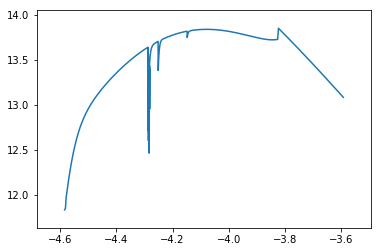

In [10]:
#SED and spectrum quantities
numWave = numKept
wave = [0.0 for i in range(numWave)]
log10Wave = [0.0 for i in range(numWave)]
log10Flux = [0.0 for i in range(numWave)]
for i in range(numWave):
    wave[i] = cm2nm * masterLams2[i]
    log10Wave[i] = math.log10(masterLams2[i])
    log10Flux[i] = log10e * masterFlux[1][i]

#Print absolute spectral energy distribution (SED)
outFile = outPath + sedFile
with open(outFile, 'w', encoding='utf-8') as sedHandle:
#with open(sedFile, 'w') as sedHandle:
    sedHandle.write(inputParamString)
    sedHandle.write("Number of lines treated with Voigt profiles: " + str(numGaussLines) + "\n")
    sedHandle.write("wave (nm)  log10(flux) (cgs) \n")
    for i in range(numKept):
        flux = log10Flux[i]
        outLine = str(wave[i]) + " " + str(flux) + "\n"
        sedHandle.write(outLine)

#Initial pylab plot set-up
pylab.title = "Spectral energy distribution (SED)"
pylab.ylabel = "log_10 F_lambda (ergs s^-1 cm^-2 cm^-1)"
pylab.xlabel = "log_10 lambda (nm)"
xMin = min(log10Wave) - 0.1
xMax = max(log10Wave) + 0.1
pylab.xlim(xMin, xMax)
yMax = max(log10Flux) + 0.2
yMin = min(log10Flux) - 0.2
pylab.ylim(yMin, yMax)
#
pylab.plot(log10Wave, log10Flux)



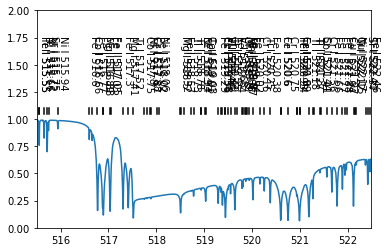

In [11]:
waveSS = [0.0 for i in range(numSpecSyn)]
for i in range(numSpecSyn):
    waveSS[i] = cm2nm * specSynLams2[i]
    
#Print rectified high resolution spectrum of synthesis region
outFile = outPath + specFile
with open(outFile, 'w', encoding='utf-8') as specHandle:
#with open(specFile, 'w') as specHandle:    
    specHandle.write(inputParamString + "\n")
    specHandle.write("Number of lines treated with Voigt profiles: " + str(numGaussLines) + "\n")
    specHandle.write("wave (nm)   normalized flux \n")
    for i in range(numSpecSyn):
        outLine = str(waveSS[i]) + " " + str(specSynFlux[0][i]) + "\n"
        specHandle.write(outLine)    

pylab.title = "Synthetic spectrum"
pylab.ylabel = "F_lambda/F^C_lambda"
pylab.xlabel = "lambda (nm)"
pylab.xlabel = "log_10 lambda (nm)"
xMin = min(waveSS)
xMax = max(waveSS)
pylab.xlim(xMin, xMax)
pylab.ylim(0.0, 2.0)
pylab.plot(waveSS, specSynFlux[0])
#Add spectral line labels:
for i in range(numGaussLines):
    thisLam = cm2nm * list2Lam0[gaussLine_ptr[i]]
    thisLam = round(thisLam, 2)
    thisLbl = list2Element[gaussLine_ptr[i]] + " " + \
    list2StageRoman[gaussLine_ptr[i]] + " " + str(thisLam)
    xPoint = [thisLam, thisLam]
    yPoint = [1.05, 1.1]
    pylab.plot(xPoint, yPoint, color='black')
    pylab.text(thisLam, 1.7, thisLbl, rotation=270)

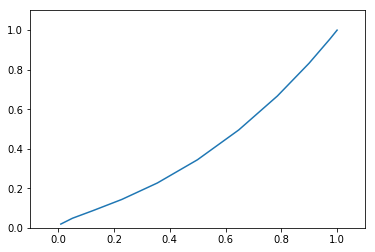

In [12]:
#Pring narrow band Gaussian filter quantities: 
#    limb darkening curve (LDC) and discrete fourier cosine transform of LDC

outFile = outPath + ldcFile
normTuneBandIntens = [0.0 for i in range(numThetas)]
for i in range(numThetas):
    normTuneBandIntens[i] = tuneBandIntens[i]/tuneBandIntens[0]
    
with open(outFile, 'w', encoding='utf-8') as ldcHandle:
#with open(ldcFile, 'w') as ldcHandle:    
    ldcHandle.write(inputParamString)
    ldcHandle.write("Narrow band limb darkening curve (LDC) \n")
    ldcHandle.write("cos(theta)   I(mu)/I(0) \n")
    outLine = str(cosTheta[1][i]) + " " + str(normTuneBandIntens[i]) + "\n" 
    ldcHandle.write(outLine)    
    ldcHandle.write("\n ")    
    ldcHandle.write("Discrete fourier cosine transform of LDC \n")
    ldcHandle.write("k (RAD/RAD)   I(k) \n")
    for i in range(numK):
        outLine = str(ft[0][i]) + " " + str(ft[1][i]) + "\n"
        ldcHandle.write(outLine)

pylab.title = "Narrow band imb darkening"
pylab.ylabel = "I_lambda/I_lambda(0)"
pylab.xlabel = "cos(theta) (RAD)"
pylab.xlim(-0.1, 1.1)
pylab.ylim(0, 1.1)
pylab.plot(cosTheta[1], normTuneBandIntens)


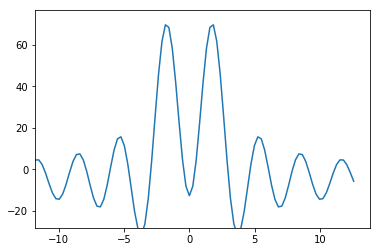

In [13]:

pylab.title = "Fourier cosine transform of I_lambda(theta)"
pylab.ylabel = "I_theta"
pylab.xlabel = "Angular freq (RAD/RAD)"
xMin = 0.9 * min(ft[0])
xMax = 1.1 * max(ft[0])
pylab.xlim(xMin, xMax)
yMin = 0.9 * min(ft[1])
yMax = 1.1 * max(ft[1])
pylab.ylim(yMin, yMax)
pylab.plot(ft[0], ft[1])

In [14]:
#// *****************************
#// 
#//
#//
#// User-defined two-level atom and line profile section:
#//
#//
#//
#//##################################

#    // Set up grid of line lambda points sampling entire profile (cm):
numCore = 5 #//half-core
numWing = 15 #//per wing 
numPoints = 2 * (numCore + numWing) - 1 #// + 1;  //Extra wavelength point at end for monochromatic continuum tau scale
#//linePoints: Row 0 in cm (will need to be in nm for Plack.planck), Row 1 in Doppler widths
linePoints = LineGrid.lineGridVoigt(userLam0, userMass, xiT, numDeps, teff, numCore, numWing) #//cm

#// Get Einstein coefficient for spontaneous de-excitation from f_ij to compute natural 
#// (radiation) roadening:  Assumes ration of statisitcal weight, g_j/g_i is unity
#logAij = math.log(6.67e13) + math.log(10.0)*userLogF - 2.0*math.log(cm2nm*userLam0)
log10Aij = math.log10(6.67e13) + userLogF - 2.0*math.log10(cm2nm*userLam0)
#////
#//Compute area-normalized depth-independent line profile "phi_lambda(lambda)"
if (ifVoigt == True):
    lineProf = LineProf.voigt2(linePoints, userLam0, log10Aij, userLogGammaCol,
                numDeps, teff, tauRos, temp, pGas, tempSun, pGasSun)
else: 
    lineProf = LineProf.voigt(linePoints, userLam0, log10Aij, userLogGammaCol, \
                      numDeps, teff, tauRos, temp, pGas, tempSun, pGasSun, hjertComp, dbgHandle)
    

#//
#// Level population now computed in LevelPops.levelPops()

#//
#// This holds 2-element temperature-dependent base 10 logarithmic parition fn:
thisUwV[0] = 0.0 #//default initialization
thisUwV[1] = 0.0
logNums = [ [ 0.0 for i in range(numDeps) ] for j in range(numStages+2) ]

thisLogN = [0.0 for i in range(numDeps)] 
for i in range(numDeps):
    thisLogN[i] = logE10*(userA12 - 12.0) + logNH[i]
   
#//load arrays for stagePops2():
#//Default is to set both temperature-dependent values to to the user-input value:
    
chiIArr[0] = userChiI1
chiIArr[1] = userChiI2
chiIArr[2] = userChiI3
chiIArr[3] = userChiI4
log10UwAArr[0][0] = math.log10(userGw1)
log10UwAArr[0][1] = math.log10(userGw1)
log10UwAArr[1][0] = math.log10(userGw2)
log10UwAArr[1][1] = math.log10(userGw2)
log10UwAArr[2][0] = math.log10(userGw3)
log10UwAArr[2][1] = math.log10(userGw3)
log10UwAArr[3][0] = math.log10(userGw4)
log10UwAArr[3][1] = math.log10(userGw4)

#//One phantom molecule:
fakeNumMols = 1
fakeLogNumB = [ [ 0.0 for i in range(numDeps) ] for j in range(1) ]

for i in range(numDeps):
    fakeLogNumB[0][i] = -49.0
    
fakeDissEArr = [ 0.0 for i in range(1) ]
fakeDissEArr[0] = 29.0 #//eV
fakeLog10UwBArr = [ [ 0.0 for i in range(2) ] for j in range(1) ]
fakeLog10UwBArr[0][0] = 0.0
fakeLog10UwBArr[0][1] = 0.0
fakeLogQwABArr = [ [ 0.0 for i in range(5) ] for j in range(fakeNumMols) ]

for im in range(fakeNumMols):
    for kk in range(5):
        fakeLogQwABArr[im][kk] = math.log(300.0)

fakeLogMuABArr = [0.0 for i in range(1)]
fakeLogMuABArr[0] = math.log(2.0) + Useful.logAmu() #//g 
logN = LevelPopsServer.stagePops2(thisLogN, newNe, chiIArr, log10UwAArr,   \
                fakeNumMols, fakeLogNumB, fakeDissEArr, fakeLog10UwBArr, fakeLogQwABArr, fakeLogMuABArr, \
                numDeps, temp)

for iTau in range(numDeps):
    logNums[0][iTau] = logN[0][iTau]
    logNums[1][iTau] = logN[1][iTau]
    logNums[4][iTau] = logN[2][iTau]
    logNums[5][iTau] = logN[3][iTau]
    logNums[6][iTau] = logN[4][iTau]
    #//logNums[6][iTau] = logN[4][iTau];
  

stage_ptr = 0 #//default initialization is neutral stage
if (userStage == 0):
    stage_ptr = 0
    
if (userStage == 1):
    stage_ptr = 1
    
if (userStage == 2):
    stage_ptr = 4
    
if (userStage == 3):
    stage_ptr = 5
    
numHelp = LevelPopsServer.levelPops(userLam0, logN[stage_ptr], userChiL, thisUwV, \
                    userGwL, numDeps, temp);
          
for iTau in range(numDeps):
    logNums[2][iTau] = numHelp[iTau]
    #//Log of line-center wavelength in cm
    
logLam0 = math.log(userLam0)
#// energy of b-b transition
logTransE = Useful.logH() + Useful.logC() - logLam0 - Useful.logEv() #// last term converts back to cgs units
#// Energy of upper E-level of b-b transition
chiU = userChiL + math.exp(logTransE)
numHelp = LevelPopsServer.levelPops(userLam0, logN[stage_ptr], chiU, thisUwV, userGwL, \
         numDeps, temp)
for iTau in range(numDeps):
    logNums[3][iTau] = numHelp[iTau] #//upper E-level - not used - fake for testing with gS3 line treatment
    
#//
#//Compute depth-dependent logarithmic monochromatic extinction co-efficient, kappa_lambda(lambda, tauRos):

lineLambdas = [0.0 for i in range(numPoints)]   
for il in range(numPoints):
    lineLambdas[il] = linePoints[0][il] + userLam0
            
logKappaL = LineKappa.lineKap(userLam0, logNums[2], userLogF, linePoints, lineProf, \
                       numDeps, zScale, tauRos, temp, rho)

logTotKappa = LineKappa.lineTotalKap(lineLambdas, logKappaL, numDeps, logKappa, \
             numLams, lambdaScale)
#//
#//Compute monochromatic optical depth scale, Tau_lambda throughout line profile
#//CAUTION: Returns numPoints+1 x numDeps array: the numPoints+1st row holds the line centre continuum tau scale
logTauL = LineTau2.tauLambda(numPoints, lineLambdas, logTotKappa, \
               numDeps, kappa500, tauRos, logTotalFudge)

#//Evaluate formal solution of rad trans eq at each lambda throughout line profile
#// Initial set to put lambda and tau arrays into form that formalsoln expects

lineIntens = [ [ 0.0 for i in range(numThetas) ] for j in range(numPoints) ]

lineIntensLam = [0.0 for i in range(numThetas)]

lineFlux = [ [ 0.0 for i in range(numPoints) ] for j in range(2) ]
lineFluxLam = [0.0 for i in range(2)]

if (ifScatt == True):
    lineMode = True
else:
    lineMode = False
    
for il in range(numPoints):

    for id in range(numDeps):
        thisTau[1][id] = logTauL[il][id]
        thisTau[0][id] = math.exp(logTauL[il][id])
        #//console.log("il " + il + " id " + id + " logTauL[il][id] " + logE*logTauL[il][id]);
        

    lineIntensLam = FormalSoln.formalSoln(numDeps, \
                cosTheta, lineLambdas[il], thisTau, temp, lineMode)
    #//lineFluxLam = flux2(lineIntensLam, cosTheta);
    for it in range(numThetas):
        lineIntens[il][it] = lineIntensLam[it]
        #//console.log("il " + il + " it " + it + "lineIntensLam[it] " + lineIntensLam[it]);
    #} //it loop - thetas
#} //il loop
lineFlux = Flux.flux3(lineIntens, lineLambdas, cosTheta, phi, cgsRadius, omegaSini, macroVkm)

#//Continuum rectify line spectrum:
#//
contFlux2 = ToolBox.interpolV(contFlux[0], lambdaScale, lineLambdas)

lineFlux2 = [ [ 0.0 for i in range(numPoints) ] for j in range(2) ]
for i in range(numPoints):
    lineFlux2[0][i] = lineFlux[0][i] / contFlux2[i]
    lineFlux2[1][i] = math.log(lineFlux2[0][i])
   

#//Get equivalent width, W_lambda, in pm - picometers:
#//Wlambda = eqWidth(lineFlux2, linePoints, lam0); //, fluxCont);

WlambdaLine = PostProcess.eqWidthSynth(lineFlux2, lineLambdas)    
print("W_lambda line: ", WlambdaLine, " pm")

W_lambda line:  2459.6455761463003  pm


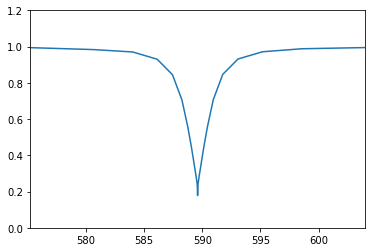

In [15]:
#//
lineWave = [0.0 for i in range(numPoints)]
#Print rectified high resolution spectrum of synthesis region
outFile = outPath + lineFile

with open(outFile, 'w', encoding='utf-8') as lineHandle:
#with open(lineFile, 'w') as lineHandle:
    lineHandle.write(inputParamString + "\n")
    lineHandle.write("User-defined two-level atom and line: Equivalent width: " + str(WlambdaLine) + " pm \n")
    lineHandle.write("wave (nm)   normalized flux \n")
    for i in range(numPoints):
        lineWave[i] = cm2nm*lineLambdas[i]
        outLine = str(lineWave[i]) + " " + str(lineFlux2[0][i]) + "\n"
        lineHandle.write(outLine)
    lineHandle.write("\n")
    lineHandle.write("log_10 energy level populations (cm^-3) \n")
    lineHandle.write("tauRos    n_l    n_I    n_II    N_III   N_IV")
    for i in range(numDeps):
        nI = log10e * logNums[0][i]
        nII = log10e * logNums[1][i]
        nl = log10e * logNums[2][i]
        nIII = log10e * logNums[4][i]
        nIV = log10e * logNums[5][i]
        outLine = str(log10tauRos[i]) + " " + str(nl) + " " + str(nI) + " " + str(nII) + " " + str(nIII) + " " + str(nIV) + "\n" 
        lineHandle.write(outLine)

#Initial pylab plot set-up
pylab.title = "Continuum normalized spectrum"
pylab.ylabel = "F_lambda/F^C_lambda"
pylab.xlabel = "lambda (nm)"
xMin = min(lineWave)
xMax = max(lineWave)
pylab.xlim(xMin, xMax)
pylab.ylim(0, 1.2)
        
pylab.plot(lineWave, lineFlux2[0])
    
#This should come at the end:
dbgHandle.close()
      